#### Author: Deni Susanto  
Email: densu@connect.hku.hk  
UID: 3035361635

In [2]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import pandas as pd
import os
from os import listdir
from os.path import join, isfile, splitext, basename, isdir
import numpy as np
import dlib
import imutils
import matplotlib.pyplot as plt
import time
import math
from shutil import copyfile
import pickle
import gc

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import BatchNormalization, Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, AveragePooling2D, ZeroPadding2D, Concatenate, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping #prevent losing model training since my computer shuts down alot when overheat
from tensorflow.keras.utils import to_categorical, Sequence

import matplotlib.pyplot as plt

from facial_landmark import FacialLandmark #this py file is created to help on this project
from facial_landmark_unopt import FacialLandmarkUnopt #unoptimized version
import models_collection

In [3]:
# For visualisation
def showImage(title, image):
    cv2.imshow(title, image)
    cv2.moveWindow(title,0,0)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def printImage(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

In [4]:
PICTURES_DIR = "./data/image_pool"
FILTERED_DIR = "./data/filtered_image_pool"

IMAGES_DATA_PKL_PATH = "./data/images_dataset.pkl"
IMAGES_DATA_PKL_COLUMNS = ["image_name", "image_width", "image_height", "age", "gender", "face_landmark", "race"]
VIEWED_PKL_PATH = "./data/viewed_image.pkl"
VIEWED_PKL_COLUMNS = ["image_name"]

BACKUP_IMAGES_DATA_PKL_PATH = "./data/auto_backup/images_dataset_auto_bck.pkl"
BACKUP_VIEWED_PKL_PATH = "./data/auto_backup/viewed_image_auto_bck.pkl"

# Image Pool Cleaning / Preprocessing

- Constructing PKL/CSV (Extracting information from the image pool)
- Detect if face is visible
- Map face's facial landmark and save it into table 
- Crop picture to only display the face, hoping it will reduce noise captured by the model
- Exclude some extreme age, i.e. <10 and >100 years old

Since the cleaning process takes around 10 hours, this program enables you to continue from where you last left the cleaning progress.

Due to overheating, computer often shuts down suddenly and corrupt the PKL file. So, autobackup system is made for this one. In case the main file is corrupted, check the auto_backup folder for last version of file backedup

In [8]:
image_names_paths = [(image, join(PICTURES_DIR, image)) for image in listdir(PICTURES_DIR) if isfile(join(PICTURES_DIR, image))]
detector = dlib.get_frontal_face_detector()

if isfile(IMAGES_DATA_PKL_PATH):
    filtered_images_df = pd.read_pickle(IMAGES_DATA_PKL_PATH)
else:
    filtered_images_df = pd.DataFrame(columns = IMAGES_DATA_PKL_COLUMNS)
    
if isfile(VIEWED_PKL_PATH):
    viewed_df = pd.read_pickle(VIEWED_PKL_PATH)
else:
    viewed_df = pd.DataFrame(columns = VIEWED_PKL_COLUMNS)

counter = 0
succ_counter = filtered_images_df.shape[0]
viewed_list, rows, succ_images = [], [], []
start_time = time.time()
batch_viewed = True
for idx, (image_name, image_path) in enumerate(image_names_paths):
    counter += 1
    imageType = splitext(basename(image_path))[1]
    if (not image_name in viewed_df['image_name'].values) and (imageType == ".jpg" or imageType == ".png"):
        viewed_list.append(image_name)
        batch_viewed = False
        try:
            age, gender, race, date_type = image_name.split('_')
        except:
            continue
        if int(age) > 8 and int(age) < 100:
            image = cv2.imread(image_path)
            facial_landmark = FacialLandmark(image)
            if facial_landmark.one_bb and facial_landmark.landmark_detected:
                face_only = facial_landmark.get_full_face_only()
                if len(face_only) > 0:
                    row = []
                    save_path = join(FILTERED_DIR, image_name)
                    succ_images.append(tuple((save_path, face_only)))
                    row.append(image_name)
                    row.append(facial_landmark.image_width)
                    row.append(facial_landmark.image_height)
                    row.append(age)
                    row.append(gender)
                    row.append(facial_landmark.landmark)
                    row.append(race)
                    rows.append(row)
                    succ_counter += 1
                    
    if counter % PROCESSING_BATCH == 0 or idx == len(image_names_paths) - 1:
        if not batch_viewed:
            print("Processed", counter, "images -", "Success:", succ_counter ,"=== take", time.time() - start_time, "second(s) to process this batch ===")
            batch_viewed = True
        else:
            print("Image processed:", counter, "=== IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY ===", "Successful filtered total:", succ_counter)
        start_time = time.time()
        for save_path, face_image in succ_images:
            cv2.imwrite(save_path, face_image)
        if len(viewed_list) > 0:
            #auto backup file, prevent corruption when system suddenly shut down
            if isfile(VIEWED_PKL_PATH):
                copyfile(VIEWED_PKL_PATH, BACKUP_VIEWED_PKL_PATH)
            viewed_df = viewed_df.append(pd.DataFrame(viewed_list, columns = VIEWED_PKL_COLUMNS), ignore_index = True, sort = False)
            viewed_df.to_pickle(VIEWED_PKL_PATH)
            viewed_list = []
        if len(rows) > 0:
            #auto backup file, prevent corruption when system suddenly shut down
            if isfile(IMAGES_DATA_PKL_PATH):
                copyfile(IMAGES_DATA_PKL_PATH, BACKUP_IMAGES_DATA_PKL_PATH)
            filtered_images_df = filtered_images_df.append(pd.DataFrame(rows, columns = IMAGES_DATA_PKL_COLUMNS), ignore_index = True, sort = False)
            filtered_images_df.to_pickle(IMAGES_DATA_PKL_PATH)
            rows = []

Image processed: 10 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 20 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 30 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 40 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 50 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 60 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 70 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 80 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 90 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image proc

Image processed: 1080 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 1090 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 1100 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 1110 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 1120 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 1130 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 1140 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 1150 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 1160 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total

Image processed: 2120 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 2130 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 2140 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 2150 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 2160 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 2170 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 2180 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 2190 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 2200 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total

Image processed: 3100 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 3110 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 3120 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 3130 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 3140 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 3150 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 3160 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 3170 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 3180 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total

Image processed: 4090 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 4100 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 4110 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 4120 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 4130 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 4140 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 4150 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 4160 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 4170 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total

Image processed: 5230 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 5240 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 5250 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 5260 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 5270 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 5280 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 5290 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 5300 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 5310 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total

Image processed: 6110 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 6120 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 6130 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 6140 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 6150 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 6160 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 6170 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 6180 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 6190 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total

Image processed: 6960 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 6970 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 6980 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 6990 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 7000 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 7010 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 7020 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 7030 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 7040 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total

Image processed: 7920 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 7930 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 7940 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 7950 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 7960 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 7970 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 7980 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 7990 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 8000 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total

Image processed: 8950 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 8960 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 8970 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 8980 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 8990 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 9000 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 9010 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 9020 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 9030 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total

Image processed: 10220 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 10230 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 10240 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 10250 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 10260 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 10270 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 10280 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 10290 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 10300 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

Image processed: 10960 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 10970 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 10980 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 10990 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 11000 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 11010 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 11020 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 11030 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 11040 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

Image processed: 11850 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 11860 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 11870 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 11880 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 11890 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 11900 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 11910 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 11920 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 11930 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

Image processed: 12800 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 12810 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 12820 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 12830 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 12840 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 12850 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 12860 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 12870 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 12880 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

Image processed: 13640 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 13650 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 13660 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 13670 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 13680 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 13690 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 13700 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 13710 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 13720 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

Image processed: 14740 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 14750 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 14760 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 14770 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 14780 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 14790 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 14800 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 14810 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 14820 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

Image processed: 15670 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 15680 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 15690 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 15700 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 15710 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 15720 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 15730 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 15740 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 15750 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

Image processed: 17020 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17030 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17040 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17050 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17060 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17070 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17080 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17090 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17100 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

Image processed: 17930 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17940 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17950 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17960 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17970 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17980 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 17990 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 18000 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 18010 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

Image processed: 19020 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 19030 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 19040 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 19050 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 19060 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 19070 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 19080 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 19090 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 19100 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

Image processed: 20200 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 20210 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 20220 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 20230 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 20240 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 20250 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 20260 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 20270 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 20280 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

Image processed: 21200 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 21210 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 21220 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 21230 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 21240 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 21250 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 21260 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 21270 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 21280 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

Image processed: 22100 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22110 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22120 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22130 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22140 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22150 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22160 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22170 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22180 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

Image processed: 22910 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22920 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22930 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22940 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22950 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22960 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22970 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22980 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filtered total: 20136
Image processed: 22990 === IMAGES IN THIS BATCH HAVE BEEN PROCESSED ALREADY === Successful filte

## FIX SOME CORRUPTED FILE
Apparently, some of the pictures got corrupted due to the computer shutting down suddenly caused by overheating

In [89]:
filtered_pool_images = [(image, join(FILTERED_DIR, image)) for image in listdir(FILTERED_DIR) if isfile(join(FILTERED_DIR, image))]
counter = 0
for idx, (image_name, image_path) in enumerate(filtered_pool_images):
    image_dat = cv2.imread(image_path)
    if image_dat is None:
        print("Processing", image_name)
        image_ori = cv2.imread(join(PICTURES_DIR, image_name))
        facial_landmark = FacialLandmark(image_ori)
        face_only = facial_landmark.get_full_face_only()
        cv2.imwrite(image_path, face_only)
        counter += 1
        print("Fixed", image_name)
print("Succesfully fix", counter, "images")

Processing 39_1_3_20170110173815028.jpg
Fixed 39_1_3_20170110173815028.jpg
Processing 39_1_3_20170117141047098.jpg
Fixed 39_1_3_20170117141047098.jpg
Processing 39_1_3_20170117184917703.jpg
Fixed 39_1_3_20170117184917703.jpg
Processing 39_1_3_20170119172010681.jpg
Fixed 39_1_3_20170119172010681.jpg
Processing 39_1_3_20170119204014702.jpg
Fixed 39_1_3_20170119204014702.jpg
Processing 39_1_4_20170103163548640.jpg
Fixed 39_1_4_20170103163548640.jpg
Processing 39_1_4_20170104172929139.jpg
Fixed 39_1_4_20170104172929139.jpg
Processing 39_1_4_20170104201147354.jpg
Fixed 39_1_4_20170104201147354.jpg
Processing 39_1_4_20170104204507323.jpg
Fixed 39_1_4_20170104204507323.jpg
Processing 39_1_4_20170105001146812.jpg
Fixed 39_1_4_20170105001146812.jpg
Processing 39_1_4_20170105173036253.jpg
Fixed 39_1_4_20170105173036253.jpg
Processing 39_1_4_20170109002712574.jpg
Fixed 39_1_4_20170109002712574.jpg
Processing 39_1_4_20170117203758344.jpg
Fixed 39_1_4_20170117203758344.jpg
Processing 40_0_0_2017010

Fixed 45_0_3_20170119171701550.jpg
Processing 45_0_3_20170119171812944.jpg
Fixed 45_0_3_20170119171812944.jpg
Processing 45_0_3_20170119171853186.jpg
Fixed 45_0_3_20170119171853186.jpg
Processing 45_0_3_20170119175445883.jpg
Fixed 45_0_3_20170119175445883.jpg
Processing 45_0_3_20170119180924508.jpg
Fixed 45_0_3_20170119180924508.jpg
Processing 45_0_3_20170119181420596.jpg
Fixed 45_0_3_20170119181420596.jpg
Processing 45_0_3_20170119183426844.jpg
Fixed 45_0_3_20170119183426844.jpg
Processing 45_0_3_20170119183704615.jpg
Fixed 45_0_3_20170119183704615.jpg
Processing 45_0_3_20170119183849743.jpg
Fixed 45_0_3_20170119183849743.jpg
Processing 45_0_3_20170119184144631.jpg
Fixed 45_0_3_20170119184144631.jpg
Processing 45_0_3_20170119184153479.jpg
Fixed 45_0_3_20170119184153479.jpg
Processing 45_0_3_20170119184244311.jpg
Fixed 45_0_3_20170119184244311.jpg
Processing 45_0_3_20170119194520650.jpg
Fixed 45_0_3_20170119194520650.jpg
Processing 45_0_3_20170119194525986.jpg
Fixed 45_0_3_201701191945

Fixed 45_1_0_20170109221119437.jpg
Processing 45_1_0_20170109221130179.jpg
Fixed 45_1_0_20170109221130179.jpg
Processing 45_1_0_20170109221158465.jpg
Fixed 45_1_0_20170109221158465.jpg
Processing 45_1_0_20170110140908362.jpg
Fixed 45_1_0_20170110140908362.jpg
Processing 45_1_0_20170110141225753.jpg
Fixed 45_1_0_20170110141225753.jpg
Processing 45_1_0_20170110151448578.jpg
Fixed 45_1_0_20170110151448578.jpg
Processing 45_1_0_20170110154302056.jpg
Fixed 45_1_0_20170110154302056.jpg
Processing 45_1_0_20170110154650451.jpg
Fixed 45_1_0_20170110154650451.jpg
Processing 45_1_0_20170110160643106.jpg
Fixed 45_1_0_20170110160643106.jpg
Processing 45_1_0_20170111182452905.jpg
Fixed 45_1_0_20170111182452905.jpg
Processing 45_1_0_20170111182452911.jpg
Fixed 45_1_0_20170111182452911.jpg
Processing 45_1_0_20170115231034803.jpg
Fixed 45_1_0_20170115231034803.jpg
Processing 45_1_0_20170117001056094.jpg
Fixed 45_1_0_20170117001056094.jpg
Processing 45_1_0_20170117135009283.jpg
Fixed 45_1_0_201701171350

Fixed 46_0_0_20170117172149820.jpg
Processing 46_0_0_20170117173358796.jpg
Fixed 46_0_0_20170117173358796.jpg
Processing 46_0_0_20170117190127107.jpg
Fixed 46_0_0_20170117190127107.jpg
Processing 46_0_0_20170117190143691.jpg
Fixed 46_0_0_20170117190143691.jpg
Processing 46_0_0_20170117190211346.jpg
Fixed 46_0_0_20170117190211346.jpg
Processing 46_0_0_20170119150223726.jpg
Fixed 46_0_0_20170119150223726.jpg
Processing 46_0_0_20170119204805959.jpg
Fixed 46_0_0_20170119204805959.jpg
Processing 46_0_0_20170119204818695.jpg
Fixed 46_0_0_20170119204818695.jpg
Processing 46_0_1_20170111200735373.jpg
Fixed 46_0_1_20170111200735373.jpg
Processing 46_0_1_20170113135634688.jpg
Fixed 46_0_1_20170113135634688.jpg
Processing 46_0_1_20170113141909603.jpg
Fixed 46_0_1_20170113141909603.jpg
Processing 46_0_1_20170113142033812.jpg
Fixed 46_0_1_20170113142033812.jpg
Processing 46_0_1_20170113142208515.jpg
Fixed 46_0_1_20170113142208515.jpg
Processing 46_0_1_20170113151900392.jpg
Fixed 46_0_1_201701131519

Fixed 46_1_2_20170109002550554.jpg
Processing 46_1_2_20170109002726038.jpg
Fixed 46_1_2_20170109002726038.jpg
Processing 46_1_2_20170109011159798.jpg
Fixed 46_1_2_20170109011159798.jpg
Processing 46_1_3_20170104183801700.jpg
Fixed 46_1_3_20170104183801700.jpg
Processing 46_1_3_20170117155929032.jpg
Fixed 46_1_3_20170117155929032.jpg
Processing 46_1_3_20170117190202819.jpg
Fixed 46_1_3_20170117190202819.jpg
Processing 46_1_3_20170119202150389.jpg
Fixed 46_1_3_20170119202150389.jpg
Processing 46_1_3_20170119204838888.jpg
Fixed 46_1_3_20170119204838888.jpg
Processing 46_1_3_20170120140919993.jpg
Fixed 46_1_3_20170120140919993.jpg
Processing 46_1_4_20170104172709843.jpg
Fixed 46_1_4_20170104172709843.jpg
Processing 46_1_4_20170105170029053.jpg
Fixed 46_1_4_20170105170029053.jpg
Processing 47_0_0_20170103183440186.jpg
Fixed 47_0_0_20170103183440186.jpg
Processing 47_0_0_20170103183442514.jpg
Fixed 47_0_0_20170103183442514.jpg
Processing 47_0_0_20170103183528850.jpg
Fixed 47_0_0_201701031835

Fixed 47_0_3_20170119202114397.jpg
Processing 47_0_3_20170119202123349.jpg
Fixed 47_0_3_20170119202123349.jpg
Processing 47_0_3_20170119202334925.jpg
Fixed 47_0_3_20170119202334925.jpg
Processing 47_0_3_20170119202404381.jpg
Fixed 47_0_3_20170119202404381.jpg
Processing 47_0_3_20170119205107927.jpg
Fixed 47_0_3_20170119205107927.jpg
Processing 47_0_3_20170119205121919.jpg
Fixed 47_0_3_20170119205121919.jpg
Processing 47_0_3_20170119205127722.jpg
Fixed 47_0_3_20170119205127722.jpg
Processing 47_0_3_20170119205128991.jpg
Fixed 47_0_3_20170119205128991.jpg
Processing 47_0_3_20170119205154121.jpg
Fixed 47_0_3_20170119205154121.jpg
Processing 47_0_3_20170119205155167.jpg
Fixed 47_0_3_20170119205155167.jpg
Processing 47_0_3_20170119205156254.jpg
Fixed 47_0_3_20170119205156254.jpg
Processing 47_0_3_20170119205212904.jpg
Fixed 47_0_3_20170119205212904.jpg
Processing 47_0_3_20170119205217135.jpg
Fixed 47_0_3_20170119205217135.jpg
Processing 47_0_3_20170119205239944.jpg
Fixed 47_0_3_201701192052

Fixed 48_0_0_20170117160444920.jpg
Processing 48_0_0_20170117160506440.jpg
Fixed 48_0_0_20170117160506440.jpg
Processing 48_0_0_20170117160515849.jpg
Fixed 48_0_0_20170117160515849.jpg
Processing 48_0_0_20170117160523895.jpg
Fixed 48_0_0_20170117160523895.jpg
Processing 48_0_0_20170117164541702.jpg
Fixed 48_0_0_20170117164541702.jpg
Processing 48_0_0_20170117165848844.jpg
Fixed 48_0_0_20170117165848844.jpg
Processing 48_0_0_20170117170703274.jpg
Fixed 48_0_0_20170117170703274.jpg
Processing 48_0_0_20170117174428789.jpg
Fixed 48_0_0_20170117174428789.jpg
Processing 48_0_0_20170117183518783.jpg
Fixed 48_0_0_20170117183518783.jpg
Processing 48_0_0_20170120134009260.jpg
Fixed 48_0_0_20170120134009260.jpg
Processing 48_0_0_20170120134446448.jpg
Fixed 48_0_0_20170120134446448.jpg
Processing 48_0_0_20170120222650520.jpg
Fixed 48_0_0_20170120222650520.jpg
Processing 48_0_0_20170120224756433.jpg
Fixed 48_0_0_20170120224756433.jpg
Processing 48_0_1_20170104212527708.jpg
Fixed 48_0_1_201701042125

Fixed 49_0_0_20170103182824970.jpg
Processing 49_0_0_20170104184239893.jpg
Fixed 49_0_0_20170104184239893.jpg
Processing 49_0_0_20170104184256957.jpg
Fixed 49_0_0_20170104184256957.jpg
Processing 49_0_0_20170104185007076.jpg
Fixed 49_0_0_20170104185007076.jpg
Processing 49_0_0_20170104185354638.jpg
Fixed 49_0_0_20170104185354638.jpg
Processing 49_0_0_20170104185359894.jpg
Fixed 49_0_0_20170104185359894.jpg
Processing 49_0_0_20170104185659750.jpg
Fixed 49_0_0_20170104185659750.jpg
Processing 49_0_0_20170104185744454.jpg
Fixed 49_0_0_20170104185744454.jpg
Processing 49_0_0_20170104185843894.jpg
Fixed 49_0_0_20170104185843894.jpg
Processing 49_0_0_20170104204517779.jpg
Fixed 49_0_0_20170104204517779.jpg
Processing 49_0_0_20170104204827251.jpg
Fixed 49_0_0_20170104204827251.jpg
Processing 49_0_0_20170104204831379.jpg
Fixed 49_0_0_20170104204831379.jpg
Processing 49_0_0_20170104205331460.jpg
Fixed 49_0_0_20170104205331460.jpg
Processing 49_0_0_20170104205813820.jpg
Fixed 49_0_0_201701042058

Fixed 49_1_0_20170109220635624.jpg
Processing 49_1_0_20170109220855652.jpg
Fixed 49_1_0_20170109220855652.jpg
Processing 49_1_0_20170109221050190.jpg
Fixed 49_1_0_20170109221050190.jpg
Processing 49_1_0_20170109221102358.jpg
Fixed 49_1_0_20170109221102358.jpg
Processing 49_1_0_20170109221146542.jpg
Fixed 49_1_0_20170109221146542.jpg
Processing 49_1_0_20170110125307207.jpg
Fixed 49_1_0_20170110125307207.jpg
Processing 49_1_0_20170110141243521.jpg
Fixed 49_1_0_20170110141243521.jpg
Processing 49_1_0_20170110154336582.jpg
Fixed 49_1_0_20170110154336582.jpg
Processing 49_1_0_20170111182452938.jpg
Fixed 49_1_0_20170111182452938.jpg
Processing 49_1_0_20170117154443925.jpg
Fixed 49_1_0_20170117154443925.jpg
Processing 49_1_0_20170117160556897.jpg
Fixed 49_1_0_20170117160556897.jpg
Processing 49_1_0_20170117160607343.jpg
Fixed 49_1_0_20170117160607343.jpg
Processing 49_1_0_20170117160608302.jpg
Fixed 49_1_0_20170117160608302.jpg
Processing 49_1_0_20170117160609295.jpg
Fixed 49_1_0_201701171606

### Data Splitting and Balancing

## Data generator

In [5]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels, img_path, to_fit=True, batch_size=32, dim=(256,256), n_channels=3, n_classes=5, shuffle=True):
        self.list_IDs = list_IDs
        self.labels = labels
        self.img_path = img_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        data = self._generate_data(list_IDs_temp)

        if self.to_fit:
            X, y = data
            return X, y
        else:
            return data
    
    def _generate_data(self, list_IDs):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        if self.to_fit:
            y = np.empty((self.batch_size), dtype=int)
#         print("loading", len(list_IDs), "images")
        for i, image_name in enumerate(list_IDs):
            pure_name = splitext(image_name)[0]
            split_pure_name = pure_name.split('_')
            if split_pure_name[-1] == "mirror":
                actual_image_name = "_".join(split_pure_name[:-1])+splitext(image_name)[1]
                image_path = join(self.img_path, actual_image_name)
                image_BGR_mir = cv2.imread(image_path)
                image_BGR = cv2.flip(image_BGR_mir, 1)
            else:
                image_path = join(self.img_path, image_name)
                image_BGR = cv2.imread(image_path)
            
            image_RGB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
            image_resized = cv2.resize(image_RGB, self.dim, interpolation = cv2.INTER_LINEAR)
            image_adjusted = image_resized / 255.0
            X[i,] = image_adjusted
            if self.to_fit:
                y[i,] = self.labels[image_name]
#         print("Done:", len(list_IDs),"Image loaded")
        if not self.to_fit:
            return X
        else:
            return (X,to_categorical(y, num_classes=self.n_classes))

## Data splitting and balancing

In [6]:
def add_mirror_tag(img_name):
    name_ext = splitext(img_name)
    return name_ext[0] + "_mirror" + name_ext[1]

def df_to_name_label(input_df):
    images_name = []
    images_label = {}
    for i in range(input_df.shape[0]):
        image_name = input_df.iloc[i,:]['image_name']
        race = input_df.iloc[i,:]['race']

        images_name.append(image_name)
        images_label[image_name] = (int(race))
    return (images_name, images_label)
    
RAND_STATE = 3035361635
FRAC = 1 #Tune this parameter to use just a fraction of the data. set it to 1 to use the all data in the pool
TRAIN_TEST_RATIO = 0.8
TRAIN_VAL_RATIO = 0.8
image_pool_df = pd.read_pickle(IMAGES_DATA_PKL_PATH)
#Shuffle input images
input_images = image_pool_df.sample(frac = FRAC, random_state = RAND_STATE)

n_train = int(round(input_images.shape[0] * TRAIN_TEST_RATIO))
train_val_images_df = input_images[:n_train]
test_images_df = input_images[n_train:]

#split train val
n_train_val = int(round(train_val_images_df.shape[0] * TRAIN_VAL_RATIO))
train_images_df = train_val_images_df[:n_train_val]
val_images_df = train_val_images_df[n_train_val:]

#balancing train images
unique_race_series = train_images_df.groupby('race')['image_name'].count()
print("Train set before data balancing:", unique_race_series)
unique_value = unique_race_series.values
unique_key =  unique_race_series.keys()
do_not_sample = unique_key[np.argmax(unique_value)]
sample_to = max(unique_value)

for key in unique_key:
    if not key == do_not_sample:
        key_df = train_images_df[train_images_df['race'] == key]
        samples = key_df.sample(n = sample_to - unique_race_series[key], replace = True)
        samples['image_name'] = samples['image_name'].apply(add_mirror_tag)
        train_images_df = pd.concat([train_images_df, samples], ignore_index = True)

# Shuffle train image
train_images_df = train_images_df.sample(frac = 1, random_state = RAND_STATE)
print("Processing training set")
x_train, y_train = df_to_name_label(train_images_df)
print("Processing validation set")
x_val, y_val = df_to_name_label(val_images_df)
print("Processing testing set")
x_test, y_test = df_to_name_label(test_images_df)

training_generator = DataGenerator(x_train, y_train, FILTERED_DIR)
validation_generator = DataGenerator(x_val, y_val, FILTERED_DIR)
test_generator = DataGenerator(x_test, y_test, FILTERED_DIR, batch_size=1, shuffle = False)

Train set before data balancing: race
0    5605
1    2704
2    1568
3    2179
4     830
Name: image_name, dtype: int64
Processing training set
Processing validation set
Processing testing set


Original face


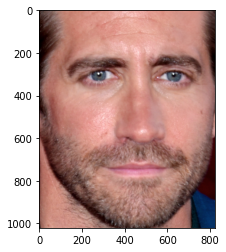

After mirrored


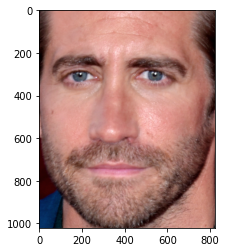

In [8]:
image_path = "jake.jpg"
image = cv2.imread(image_path)
fl = FacialLandmark(image)
image_BGR = fl.get_full_face_only()
print("Original face")
printImage(image_BGR)
image_BGR_mir = cv2.flip(image_BGR, 1)
print("After mirrored")
printImage(image_BGR_mir)

# Modelling

In [6]:
##### DONT FORGET CHANGE THESE PARAMETERS TO APPROPRIATE VALUE BEFORE RUNNING #####
# CALLBACK_MODEL_CHECKPOINT_BEST_VAL_LOSS = "./models/model_best_val_loss_alex_net.hdf5"
# CALLBACK_MODEL_CHECKPOINT_BEST_VAL_ACC = "./models/model_best_val_acc_alex_net.hdf5"

model_name = "AlexNet_optimized_v17_imbalance"
create_my_model = models_collection.create_AlexNet_optimized_v37 #This is a function btw

HISTORY_PICKLE_DIR = "./models_v2/history/" + model_name +"_history"
MODEL_SAVE_DIR = "./models_v2/" + model_name
CALLBACK_MODEL_CHECKPOINT_LAST_MODEL = join(MODEL_SAVE_DIR, "model_checkpoint_after_loop_" + model_name +".h5")
BEST_LOSS_PKL_PATH = join(HISTORY_PICKLE_DIR, "000_best_val_loss.pkl")
CONTINUE_TRAINING_PATH = join(MODEL_SAVE_DIR, "000_continue_training.pkl")

history_prefix = model_name + "_"
per_epoch = 10
max_loop = 500
save_model_every_n_epoch = 3 * per_epoch
check_save_best_loss_model_every_n_epoch = 1 * per_epoch
##### DONT FORGET CHANGE THESE PARAMETERS TO APPROPRIATE VALUE BEFORE RUNNING #####

if not os.path.exists(HISTORY_PICKLE_DIR):
    os.makedirs(HISTORY_PICKLE_DIR)
if not os.path.exists(MODEL_SAVE_DIR):
    os.makedirs(MODEL_SAVE_DIR)

#loading continue training if exist
if isfile(CONTINUE_TRAINING_PATH):
    with open(CONTINUE_TRAINING_PATH, 'rb') as handle:
        specific_start = pickle.load(handle)
else:
    specific_start = 0
print("Start at i =", specific_start)

#loading best val loss if exist
if isfile(BEST_LOSS_PKL_PATH):
    with open(BEST_LOSS_PKL_PATH, 'rb') as handle:
        best_loss = pickle.load(handle)
else:
    best_loss = float("inf")
print("Best loss =", best_loss)

callbacks = [ModelCheckpoint(CALLBACK_MODEL_CHECKPOINT_LAST_MODEL, monitor = 'val_loss', verbose = 1, save_best_only = False, save_weight_only = False, save_freq='epoch', period = per_epoch)]
# ModelCheckpoint(CALLBACK_MODEL_CHECKPOINT_BEST_VAL_LOSS, monitor = 'val_loss', verbose = 1, save_best_only = True, mode='auto', save_freq='epoch', period = 5)]
#             ModelCheckpoint(CALLBACK_MODEL_CHECKPOINT_BEST_VAL_ACC, monitor = 'val_acc', verbose = 1, save_best_only = True, mode='auto', save_freq='epoch', period = 2)]
#             EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3), EarlyStopping(monitor='val_acc', mode='auto', min_delta=1, patience = 3)

all_history = []

for i in range(specific_start, max_loop):
    if isfile(CALLBACK_MODEL_CHECKPOINT_LAST_MODEL):
        model = load_model(CALLBACK_MODEL_CHECKPOINT_LAST_MODEL)
        print("== model succesfully loaded ==")
    else:
        model = create_my_model()
        model.summary()
        print("== Created new model ==")
    pickle_name = history_prefix + str((i+1) * per_epoch) + ".pkl"
    pickle_path = join(HISTORY_PICKLE_DIR, pickle_name)
    model_history = model.fit(training_generator, validation_data = validation_generator, epochs = per_epoch, verbose = 1, callbacks = callbacks)
    
    #saving models
    curr_epoch = (i+1) * per_epoch
    #saving model manually per n epoch
    if curr_epoch != 0 and curr_epoch%save_model_every_n_epoch == 0:
        model_file_name = history_prefix + str(curr_epoch) + ".h5"
        model_saving_path = join(MODEL_SAVE_DIR, model_file_name)
        model.save(model_saving_path)
        print("==== Per_n_epoch: Model saved:", model_saving_path, "====")
    
    if curr_epoch != 0 and curr_epoch%check_save_best_loss_model_every_n_epoch == 0:
        last_loss = model_history.history['val_loss'][-1]
        if best_loss > last_loss:
            model_file_name = "000_" + history_prefix + "best_loss_" + str(curr_epoch) + ".h5"
            model_saving_path = join(MODEL_SAVE_DIR, model_file_name)
            model.save(model_saving_path)
            print("==== Loss improved ", best_loss,"to", last_loss,": Model saved:", model_saving_path, "====")
            best_loss = last_loss
            with open(BEST_LOSS_PKL_PATH, 'wb') as file_pi:
                pickle.dump(best_loss, file_pi)
            print("best val loss pkl updated")
    
    #save continue training
    cont_train = i+1
    with open(CONTINUE_TRAINING_PATH, 'wb') as file_pi:
        pickle.dump(cont_train, file_pi)
    print("training continue saved at", cont_train)
                
    all_history.append(model_history.history)
    
    #save history
    with open(pickle_path, 'wb') as file_pi:
        pickle.dump(model_history.history, file_pi)
    print("History saved:", pickle_name)
    #Trying to fix memory leak..
    del model
    del model_history
    gc.collect()
    K.clear_session()
    print("Session cleared and GC called")


Start at i = 0
Best loss = inf
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      23296     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



402/402 [==============================] - 111s 276ms/step - loss: 1.2090 - acc: 0.6064 - val_loss: 1.2341 - val_acc: 0.5806
Epoch 9/10
402/402 [==============================] - 110s 273ms/step - loss: 1.2057 - acc: 0.6074 - val_loss: 1.2328 - val_acc: 0.5800
Epoch 10/10
401/402 [============================>.] - ETA: 0s - loss: 1.2042 - acc: 0.6078
Epoch 00010: saving model to ./models_v2/AlexNet_optimized_v17_imbalance/model_checkpoint_after_loop_AlexNet_optimized_v17_imbalance.h5
402/402 [==============================] - 112s 278ms/step - loss: 1.2042 - acc: 0.6080 - val_loss: 1.2312 - val_acc: 0.5822
==== Loss improved  1.2486078083515166 to 1.2312292397022246 : Model saved: ./models_v2/AlexNet_optimized_v17_imbalance/000_AlexNet_optimized_v17_imbalance_best_loss_70.h5 ====
best val loss pkl updated
training continue saved at 7
History saved: AlexNet_optimized_v17_imbalance_70.pkl
Session cleared and GC called
== model succesfully loaded ==
Epoch 1/10
402/402 [===================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



402/402 [==============================] - 117s 291ms/step - loss: 1.1710 - acc: 0.6167 - val_loss: 1.2104 - val_acc: 0.5794
Epoch 4/10
402/402 [==============================] - 121s 301ms/step - loss: 1.1688 - acc: 0.6162 - val_loss: 1.2290 - val_acc: 0.5794
Epoch 5/10
402/402 [==============================] - 121s 301ms/step - loss: 1.1670 - acc: 0.6166 - val_loss: 1.2074 - val_acc: 0.5822
Epoch 6/10
402/402 [==============================] - 122s 302ms/step - loss: 1.1663 - acc: 0.6160 - val_loss: 1.2078 - val_acc: 0.5825
Epoch 7/10
402/402 [==============================] - 121s 301ms/step - loss: 1.1617 - acc: 0.6181 - val_loss: 1.2040 - val_acc: 0.5813
Epoch 8/10
402/402 [==============================] - 120s 298ms/step - loss: 1.1599 - acc: 0.6180 - val_loss: 1.2029 - val_acc: 0.5822
Epoch 9/10
402/402 [==============================] - 122s 304ms/step - loss: 1.1584 - acc: 0.6178 - val_loss: 1.2042 - val_acc: 0.5800
Epoch 10/10
401/402 [============================>.] - ETA:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



401/402 [============================>.] - ETA: 0s - loss: 1.1347 - acc: 0.6222
Epoch 00010: saving model to ./models_v2/AlexNet_optimized_v17_imbalance/model_checkpoint_after_loop_AlexNet_optimized_v17_imbalance.h5
402/402 [==============================] - 111s 275ms/step - loss: 1.1350 - acc: 0.6221 - val_loss: 1.1940 - val_acc: 0.5738
==== Loss improved  1.2007456624507904 to 1.1940410947799682 : Model saved: ./models_v2/AlexNet_optimized_v17_imbalance/000_AlexNet_optimized_v17_imbalance_best_loss_100.h5 ====
best val loss pkl updated
training continue saved at 10
History saved: AlexNet_optimized_v17_imbalance_100.pkl
Session cleared and GC called
== model succesfully loaded ==
Epoch 1/10
402/402 [==============================] - 120s 299ms/step - loss: 1.1329 - acc: 0.6220 - val_loss: 1.1885 - val_acc: 0.5822
Epoch 2/10
402/402 [==============================] - 115s 286ms/step - loss: 1.1282 - acc: 0.6236 - val_loss: 1.1874 - val_acc: 0.5800
Epoch 3/10
402/402 [=================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



402/402 [==============================] - 111s 276ms/step - loss: 1.1040 - acc: 0.6257 - val_loss: 1.1735 - val_acc: 0.5788
Epoch 6/10
402/402 [==============================] - 110s 274ms/step - loss: 1.1061 - acc: 0.6245 - val_loss: 1.1755 - val_acc: 0.5834
Epoch 7/10
402/402 [==============================] - 110s 274ms/step - loss: 1.1017 - acc: 0.6255 - val_loss: 1.1712 - val_acc: 0.5819
Epoch 8/10
402/402 [==============================] - 114s 283ms/step - loss: 1.1001 - acc: 0.6252 - val_loss: 1.1770 - val_acc: 0.5734
Epoch 9/10
402/402 [==============================] - 112s 279ms/step - loss: 1.0975 - acc: 0.6258 - val_loss: 1.1710 - val_acc: 0.5813
Epoch 10/10
401/402 [============================>.] - ETA: 0s - loss: 1.0964 - acc: 0.6262
Epoch 00010: saving model to ./models_v2/AlexNet_optimized_v17_imbalance/model_checkpoint_after_loop_AlexNet_optimized_v17_imbalance.h5
402/402 [==============================] - 113s 281ms/step - loss: 1.0965 - acc: 0.6260 - val_loss: 1.1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



402/402 [==============================] - 122s 304ms/step - loss: 1.0776 - acc: 0.6282 - val_loss: 1.1648 - val_acc: 0.5738
Epoch 2/10
402/402 [==============================] - 119s 297ms/step - loss: 1.0775 - acc: 0.6275 - val_loss: 1.1629 - val_acc: 0.5813
Epoch 3/10
402/402 [==============================] - 119s 295ms/step - loss: 1.0742 - acc: 0.6283 - val_loss: 1.1634 - val_acc: 0.5731
Epoch 4/10
402/402 [==============================] - 120s 299ms/step - loss: 1.0759 - acc: 0.6268 - val_loss: 1.1636 - val_acc: 0.5816
Epoch 5/10
402/402 [==============================] - 119s 297ms/step - loss: 1.0720 - acc: 0.6279 - val_loss: 1.1599 - val_acc: 0.5784
Epoch 6/10
402/402 [==============================] - 119s 297ms/step - loss: 1.0702 - acc: 0.6280 - val_loss: 1.1630 - val_acc: 0.5772
Epoch 7/10
402/402 [==============================] - 119s 295ms/step - loss: 1.0674 - acc: 0.6285 - val_loss: 1.1595 - val_acc: 0.5750
Epoch 8/10
330/402 [=======================>......] - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



402/402 [==============================] - 119s 295ms/step - loss: 1.0266 - acc: 0.6298 - val_loss: 1.1397 - val_acc: 0.5753
Epoch 2/10
402/402 [==============================] - 117s 290ms/step - loss: 1.0279 - acc: 0.6301 - val_loss: 1.1711 - val_acc: 0.5450
Epoch 3/10
402/402 [==============================] - 114s 283ms/step - loss: 1.0272 - acc: 0.6297 - val_loss: 1.1515 - val_acc: 0.5734
Epoch 4/10
402/402 [==============================] - 118s 293ms/step - loss: 1.0238 - acc: 0.6301 - val_loss: 1.1430 - val_acc: 0.5703
Epoch 5/10
402/402 [==============================] - 117s 292ms/step - loss: 1.0217 - acc: 0.6302 - val_loss: 1.1405 - val_acc: 0.5763
Epoch 6/10
402/402 [==============================] - 114s 282ms/step - loss: 1.0197 - acc: 0.6305 - val_loss: 1.1405 - val_acc: 0.5781
Epoch 7/10
402/402 [==============================] - 114s 285ms/step - loss: 1.0190 - acc: 0.6307 - val_loss: 1.1446 - val_acc: 0.5750
Epoch 8/10
402/402 [==============================] - 119s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



402/402 [==============================] - 121s 300ms/step - loss: 0.9807 - acc: 0.6310 - val_loss: 1.1299 - val_acc: 0.5778
Epoch 4/10
402/402 [==============================] - 121s 302ms/step - loss: 0.9774 - acc: 0.6316 - val_loss: 1.1246 - val_acc: 0.5794
Epoch 5/10
402/402 [==============================] - 119s 297ms/step - loss: 0.9783 - acc: 0.6310 - val_loss: 1.1324 - val_acc: 0.5631
Epoch 6/10
402/402 [==============================] - 119s 297ms/step - loss: 0.9773 - acc: 0.6311 - val_loss: 1.1210 - val_acc: 0.5797
Epoch 7/10
402/402 [==============================] - 120s 298ms/step - loss: 0.9770 - acc: 0.6308 - val_loss: 1.1204 - val_acc: 0.5816
Epoch 8/10
402/402 [==============================] - 119s 297ms/step - loss: 0.9758 - acc: 0.6309 - val_loss: 1.1232 - val_acc: 0.5803
Epoch 9/10
402/402 [==============================] - 120s 297ms/step - loss: 0.9758 - acc: 0.6312 - val_loss: 1.1223 - val_acc: 0.5769
Epoch 10/10
401/402 [============================>.] - ETA:

Epoch 4/10
402/402 [==============================] - 116s 289ms/step - loss: 0.9256 - acc: 0.6326 - val_loss: 1.1093 - val_acc: 0.5800
Epoch 5/10
402/402 [==============================] - 117s 291ms/step - loss: 0.9272 - acc: 0.6322 - val_loss: 1.1117 - val_acc: 0.5788
Epoch 6/10
402/402 [==============================] - 116s 288ms/step - loss: 0.9252 - acc: 0.6325 - val_loss: 1.1180 - val_acc: 0.5816
Epoch 7/10
402/402 [==============================] - 115s 287ms/step - loss: 0.9261 - acc: 0.6319 - val_loss: 1.1053 - val_acc: 0.5791
Epoch 8/10
402/402 [==============================] - 118s 293ms/step - loss: 0.9277 - acc: 0.6324 - val_loss: 1.1150 - val_acc: 0.5709
Epoch 9/10
402/402 [==============================] - 116s 289ms/step - loss: 0.9244 - acc: 0.6324 - val_loss: 1.1121 - val_acc: 0.5753
Epoch 10/10
401/402 [============================>.] - ETA: 0s - loss: 0.9268 - acc: 0.6320
Epoch 00010: saving model to ./models_v2/AlexNet_optimized_v17_imbalance/model_checkpoint_af

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



402/402 [==============================] - 118s 294ms/step - loss: 0.9146 - acc: 0.6328 - val_loss: 1.1216 - val_acc: 0.5772
Epoch 4/10
402/402 [==============================] - 119s 297ms/step - loss: 0.9136 - acc: 0.6334 - val_loss: 1.1124 - val_acc: 0.5759
Epoch 5/10
402/402 [==============================] - 120s 298ms/step - loss: 0.9125 - acc: 0.6336 - val_loss: 1.1114 - val_acc: 0.5741
Epoch 6/10
402/402 [==============================] - 119s 295ms/step - loss: 0.9127 - acc: 0.6333 - val_loss: 1.1230 - val_acc: 0.5806
Epoch 7/10
402/402 [==============================] - 118s 295ms/step - loss: 0.9168 - acc: 0.6331 - val_loss: 1.1091 - val_acc: 0.5791
Epoch 8/10
402/402 [==============================] - 119s 297ms/step - loss: 0.9113 - acc: 0.6332 - val_loss: 1.1167 - val_acc: 0.5750
Epoch 9/10
402/402 [==============================] - 120s 298ms/step - loss: 0.9132 - acc: 0.6330 - val_loss: 1.1136 - val_acc: 0.5856
Epoch 10/10
401/402 [============================>.] - ETA:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



402/402 [==============================] - 120s 298ms/step - loss: 0.9104 - acc: 0.6332 - val_loss: 1.1460 - val_acc: 0.5847
Epoch 7/10
402/402 [==============================] - 121s 301ms/step - loss: 0.9106 - acc: 0.6333 - val_loss: 1.1193 - val_acc: 0.5844
Epoch 8/10
402/402 [==============================] - 119s 296ms/step - loss: 0.9094 - acc: 0.6332 - val_loss: 1.1120 - val_acc: 0.5828
Epoch 9/10
402/402 [==============================] - 118s 294ms/step - loss: 0.9083 - acc: 0.6332 - val_loss: 1.2196 - val_acc: 0.5184
Epoch 10/10
401/402 [============================>.] - ETA: 0s - loss: 0.9097 - acc: 0.6330
Epoch 00010: saving model to ./models_v2/AlexNet_optimized_v17_imbalance/model_checkpoint_after_loop_AlexNet_optimized_v17_imbalance.h5
402/402 [==============================] - 115s 285ms/step - loss: 0.9096 - acc: 0.6330 - val_loss: 1.1170 - val_acc: 0.5844
==== Per_n_epoch: Model saved: ./models_v2/AlexNet_optimized_v17_imbalance/AlexNet_optimized_v17_imbalance_360.h5 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



402/402 [==============================] - 118s 294ms/step - loss: 0.9070 - acc: 0.6333 - val_loss: 1.1114 - val_acc: 0.5725
Epoch 10/10
401/402 [============================>.] - ETA: 0s - loss: 0.9050 - acc: 0.6333
Epoch 00010: saving model to ./models_v2/AlexNet_optimized_v17_imbalance/model_checkpoint_after_loop_AlexNet_optimized_v17_imbalance.h5
402/402 [==============================] - 120s 298ms/step - loss: 0.9050 - acc: 0.6335 - val_loss: 1.1169 - val_acc: 0.5859
training continue saved at 37
History saved: AlexNet_optimized_v17_imbalance_370.pkl
Session cleared and GC called
== model succesfully loaded ==
Epoch 1/10
402/402 [==============================] - 120s 299ms/step - loss: 0.9041 - acc: 0.6337 - val_loss: 1.1087 - val_acc: 0.5806
Epoch 2/10
402/402 [==============================] - 121s 300ms/step - loss: 0.9043 - acc: 0.6332 - val_loss: 1.1158 - val_acc: 0.5781
Epoch 3/10
402/402 [==============================] - 119s 296ms/step - loss: 0.9039 - acc: 0.6339 - val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



402/402 [==============================] - 113s 280ms/step - loss: 0.9003 - acc: 0.6335 - val_loss: 1.1166 - val_acc: 0.5725
Epoch 3/10
402/402 [==============================] - 110s 273ms/step - loss: 0.9033 - acc: 0.6330 - val_loss: 1.1052 - val_acc: 0.5788
Epoch 4/10
402/402 [==============================] - 113s 281ms/step - loss: 0.9008 - acc: 0.6337 - val_loss: 1.1156 - val_acc: 0.5731
Epoch 5/10
402/402 [==============================] - 120s 298ms/step - loss: 0.9008 - acc: 0.6338 - val_loss: 1.1171 - val_acc: 0.5763
Epoch 6/10
402/402 [==============================] - 121s 301ms/step - loss: 0.9026 - acc: 0.6334 - val_loss: 1.1114 - val_acc: 0.5797
Epoch 7/10
402/402 [==============================] - 119s 296ms/step - loss: 0.9002 - acc: 0.6336 - val_loss: 1.1079 - val_acc: 0.5816
Epoch 8/10
402/402 [==============================] - 118s 293ms/step - loss: 0.8991 - acc: 0.6339 - val_loss: 1.1072 - val_acc: 0.5809
Epoch 9/10
352/402 [=========================>....] - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



402/402 [==============================] - 114s 284ms/step - loss: 0.8969 - acc: 0.6337 - val_loss: 1.1158 - val_acc: 0.5722
Epoch 5/10
402/402 [==============================] - 117s 292ms/step - loss: 0.8979 - acc: 0.6336 - val_loss: 1.1178 - val_acc: 0.5813
Epoch 6/10
402/402 [==============================] - 122s 304ms/step - loss: 0.8970 - acc: 0.6336 - val_loss: 1.1156 - val_acc: 0.5766
Epoch 7/10
402/402 [==============================] - 118s 293ms/step - loss: 0.8977 - acc: 0.6336 - val_loss: 1.1166 - val_acc: 0.5716
Epoch 8/10
402/402 [==============================] - 114s 285ms/step - loss: 0.8960 - acc: 0.6337 - val_loss: 1.1228 - val_acc: 0.5819
Epoch 9/10
402/402 [==============================] - 118s 294ms/step - loss: 0.8958 - acc: 0.6339 - val_loss: 1.1234 - val_acc: 0.5803
Epoch 10/10
401/402 [============================>.] - ETA: 0s - loss: 0.8935 - acc: 0.6344
Epoch 00010: saving model to ./models_v2/AlexNet_optimized_v17_imbalance/model_checkpoint_after_loop_Al

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



402/402 [==============================] - 129s 321ms/step - loss: 0.8925 - acc: 0.6337 - val_loss: 1.1171 - val_acc: 0.5753
Epoch 9/10
402/402 [==============================] - 128s 319ms/step - loss: 0.8960 - acc: 0.6334 - val_loss: 1.1174 - val_acc: 0.5769
Epoch 10/10
401/402 [============================>.] - ETA: 0s - loss: 0.8924 - acc: 0.6343
Epoch 00010: saving model to ./models_v2/AlexNet_optimized_v17_imbalance/model_checkpoint_after_loop_AlexNet_optimized_v17_imbalance.h5
402/402 [==============================] - 130s 323ms/step - loss: 0.8922 - acc: 0.6344 - val_loss: 1.1110 - val_acc: 0.5753
training continue saved at 41
History saved: AlexNet_optimized_v17_imbalance_410.pkl
Session cleared and GC called
== model succesfully loaded ==
Epoch 1/10
402/402 [==============================] - 125s 310ms/step - loss: 0.8908 - acc: 0.6343 - val_loss: 1.1122 - val_acc: 0.5763
Epoch 2/10
402/402 [==============================] - 121s 300ms/step - loss: 0.8912 - acc: 0.6342 - val

KeyboardInterrupt: 

# Evaluate Models

AlexNet_optimized_v34_no_others


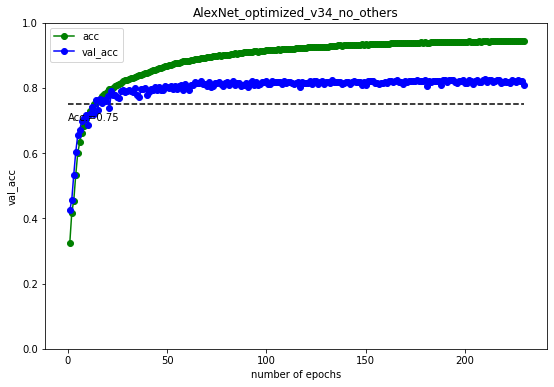

AlexNet_optimized_v23


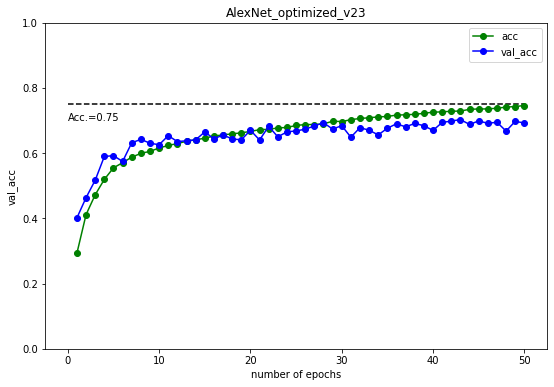

LeNet5


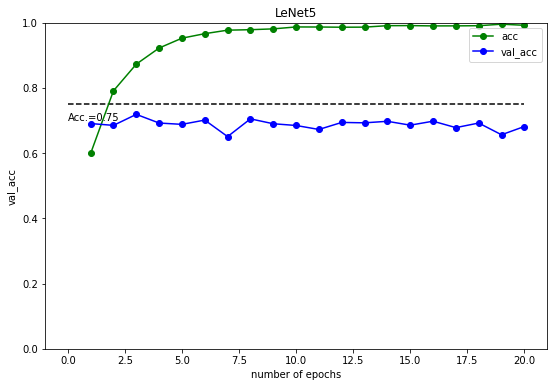

AlexNet_optimized_v9


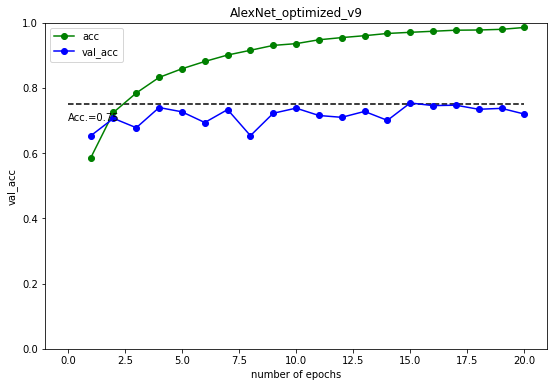

AlexNet_optimized_v27


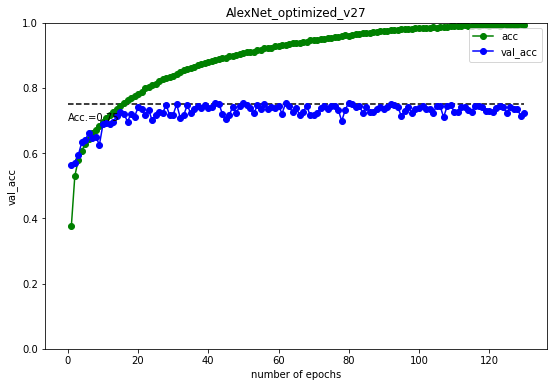

AlexNet_optimized_v5


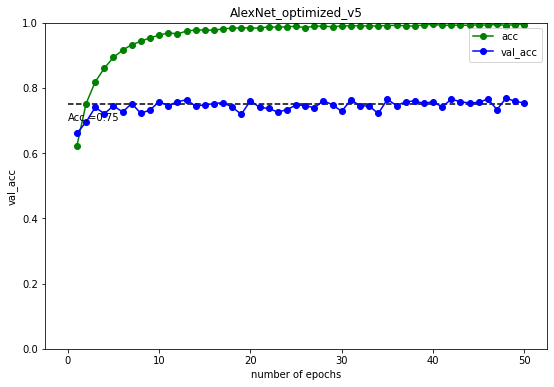

transferlearning_VGG16


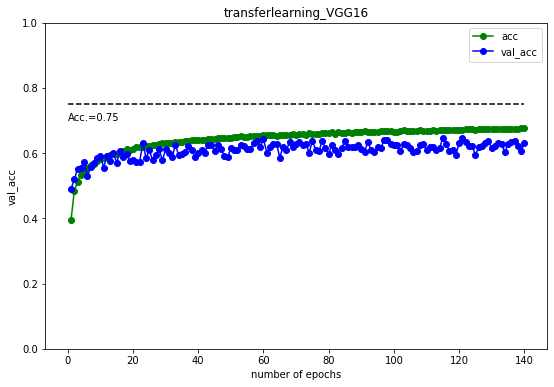

AlexNet_optimized_v19


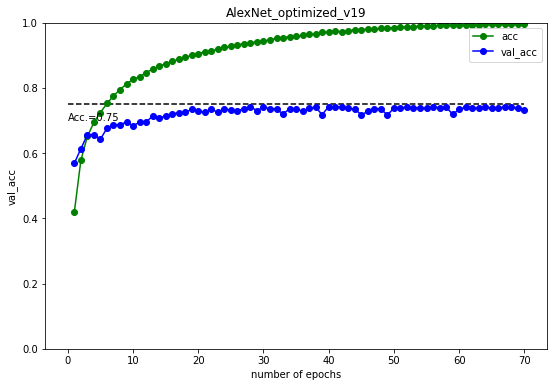

AlexNet_optimized_v11


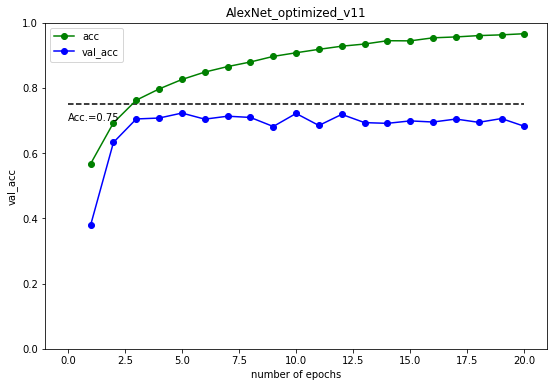

AlexNet_optimized_v15


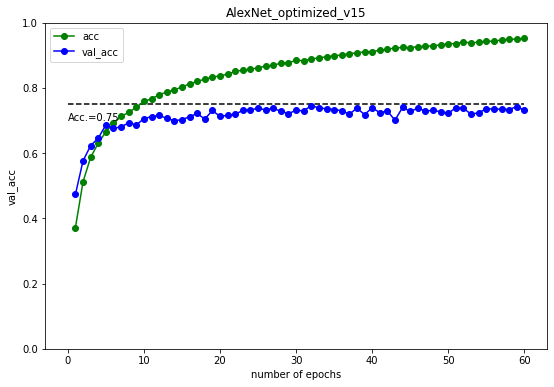

vgg_custom_net_1_v16


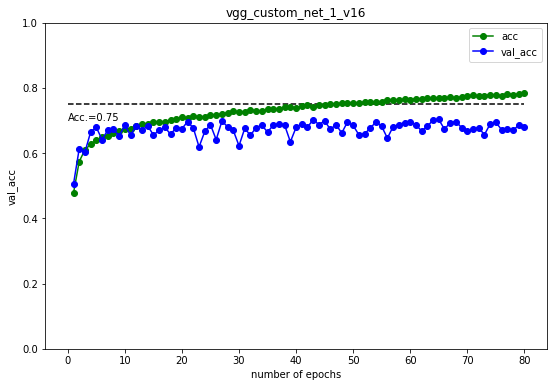

AlexNet_optimized_v4_imbalance


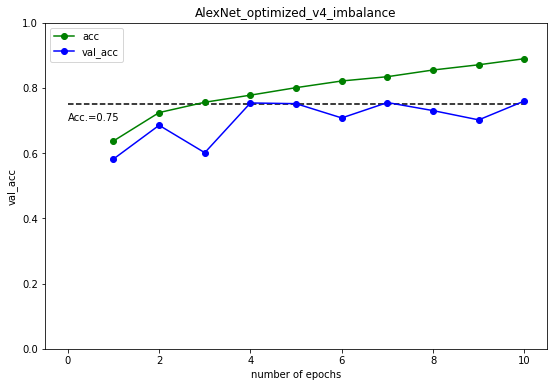

vgg_custom_net_1_v8


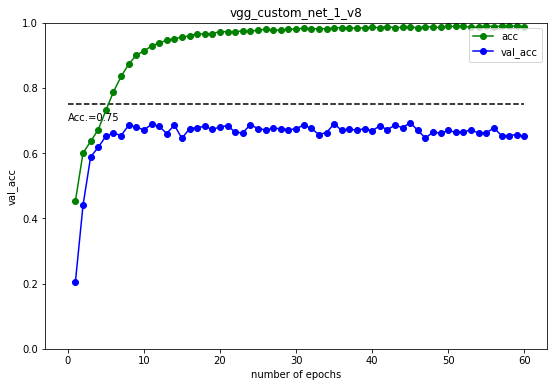

vgg_custom_net_1_v12


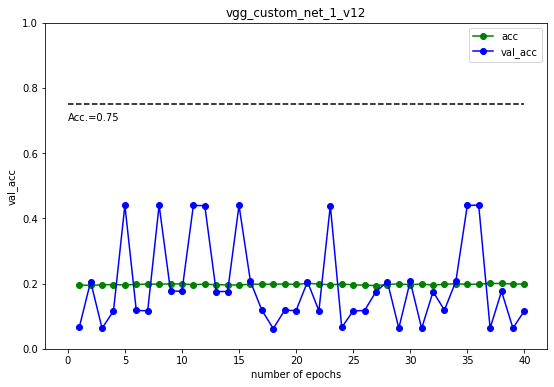

AlexNet_optimized_v36


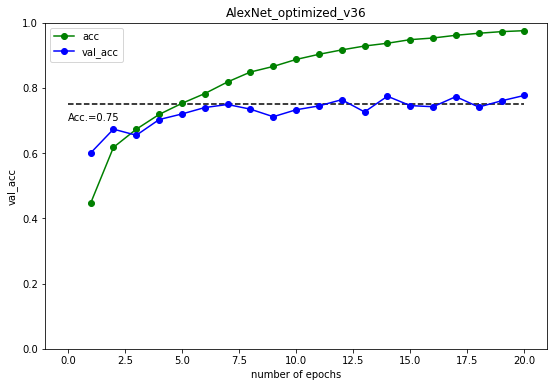

AlexNet_optimized_v32


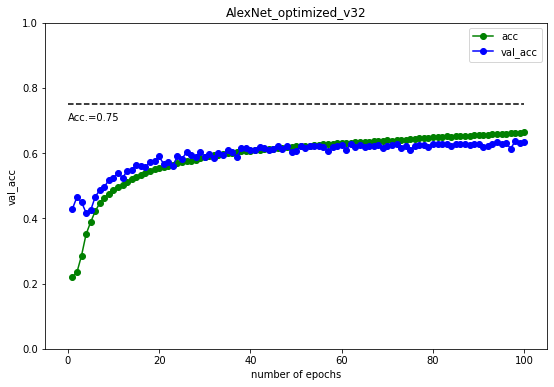

AlexNet_optimized_v10


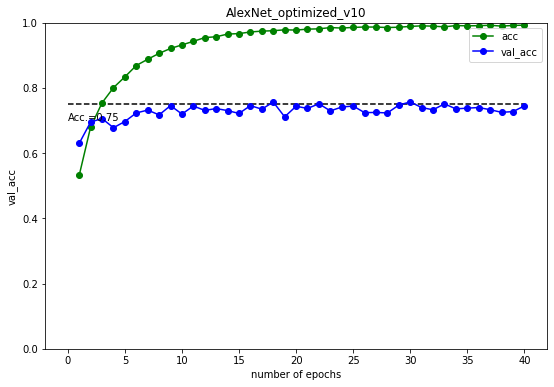

AlexNet_optimized_v14


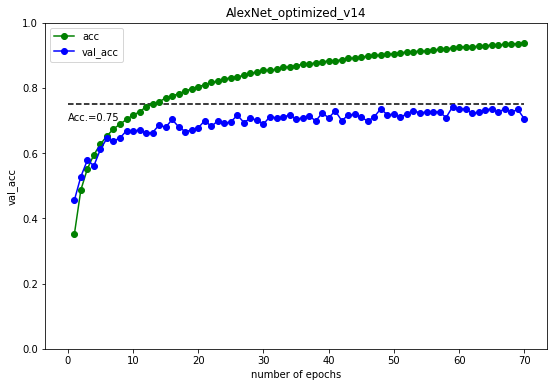

AlexNet_optimized_v18


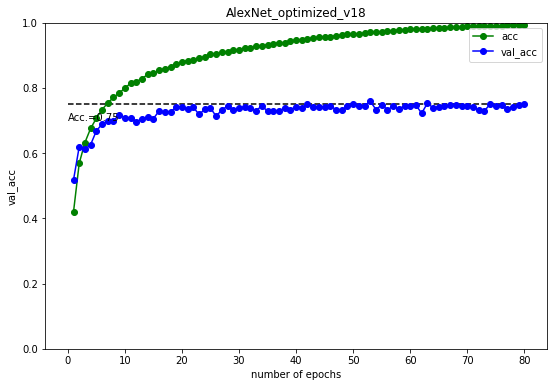

AlexNet_optimized_v37


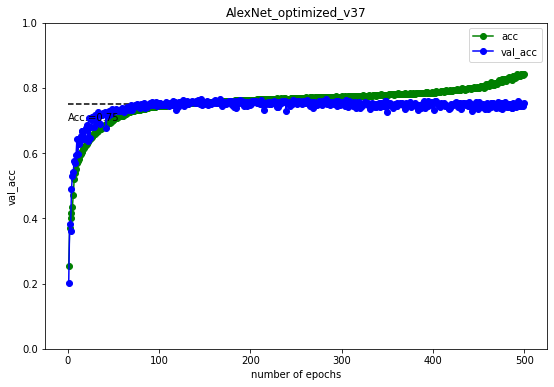

AlexNet_optimized_v33


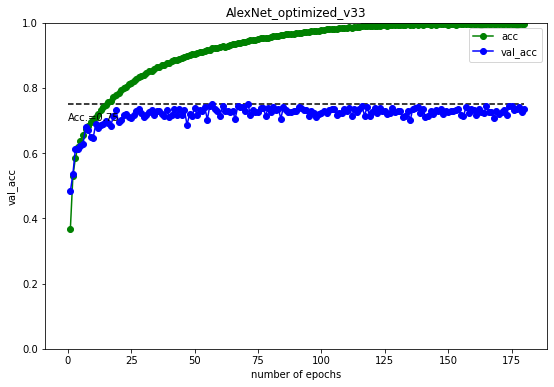

vgg_custom_net_1_v17


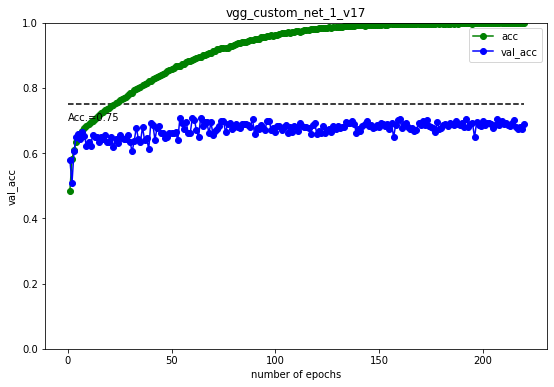

vgg_custom_net_1_v13


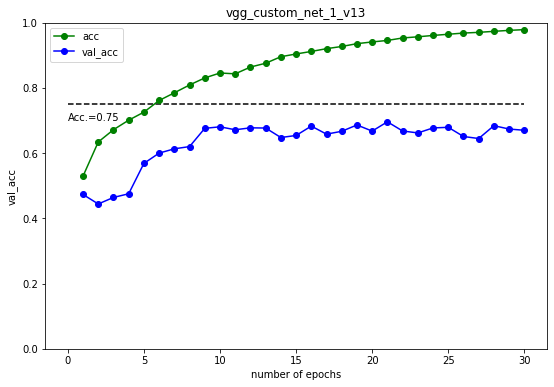

AlexNet_optimized_v15_imbalance


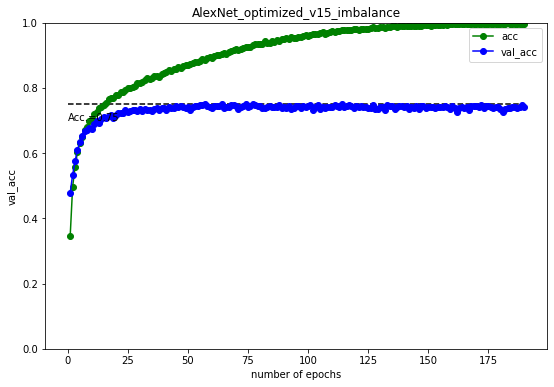

AlexNet_optimized_v4


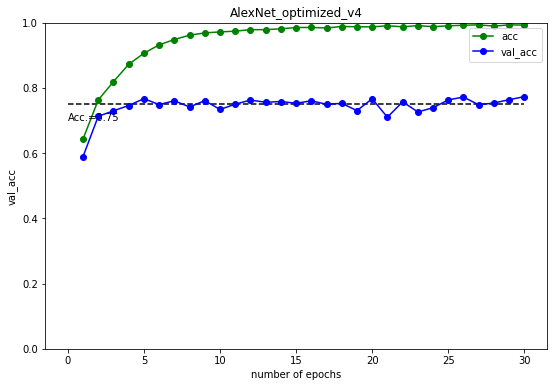

AlexNet_optimized_v22


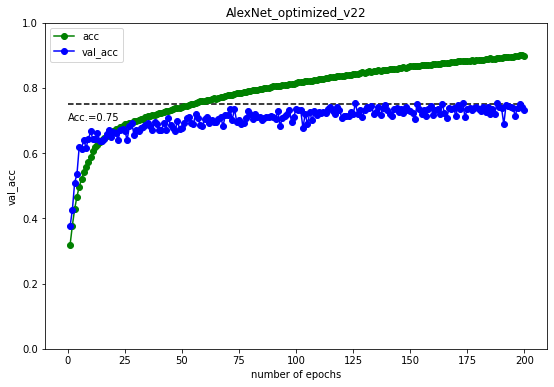

vgg_custom_net_1


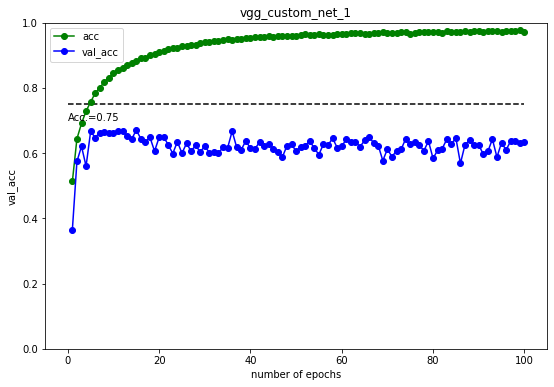

AlexNet_optimized_v8


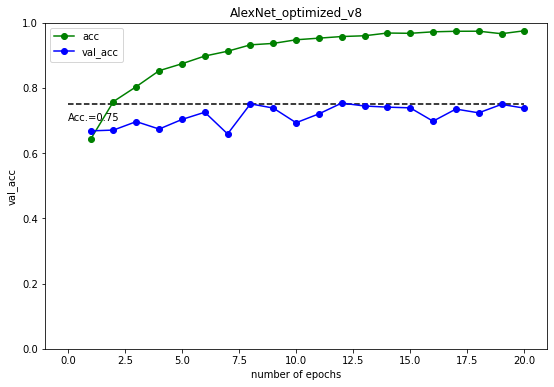

AlexNet_optimized_v26


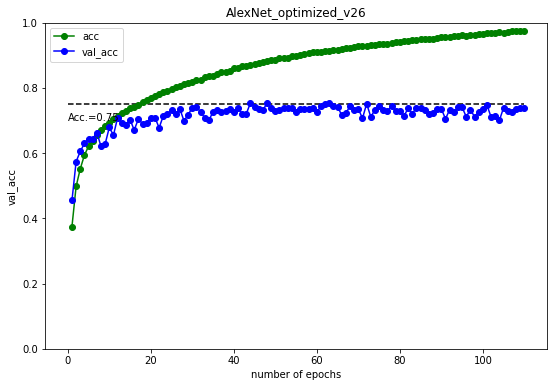

AlexNet_optimized_v35


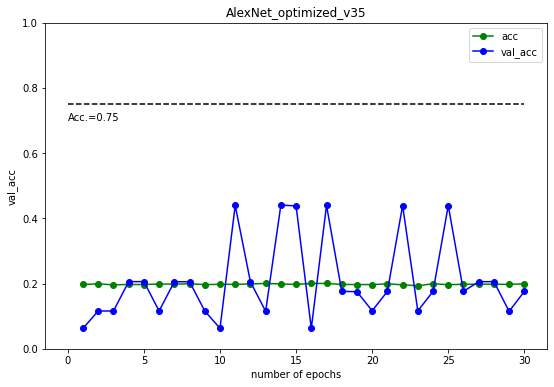

vgg_custom_net_1_v19


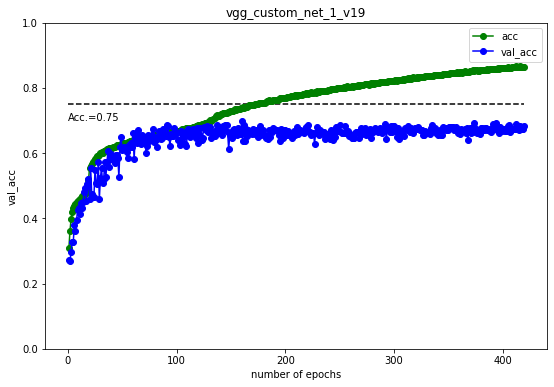

AlexNet_optimized_v31


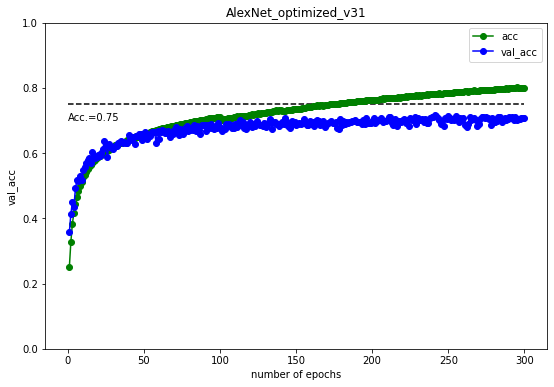

vgg_custom_net_1_v15


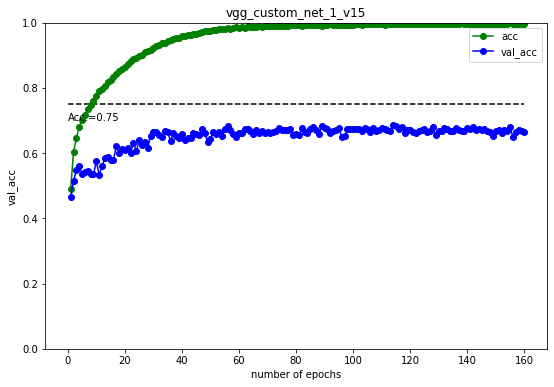

AlexNet_optimized_v39


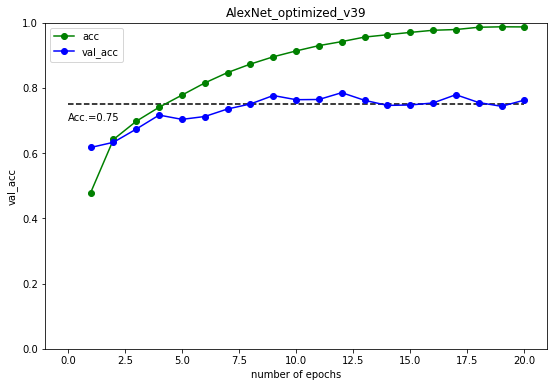

vgg_custom_net_1_v11


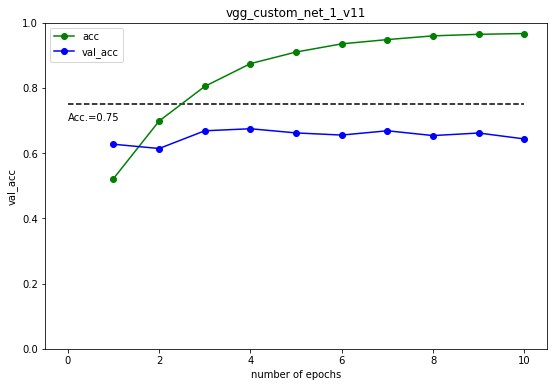

AlexNet_optimized_v12


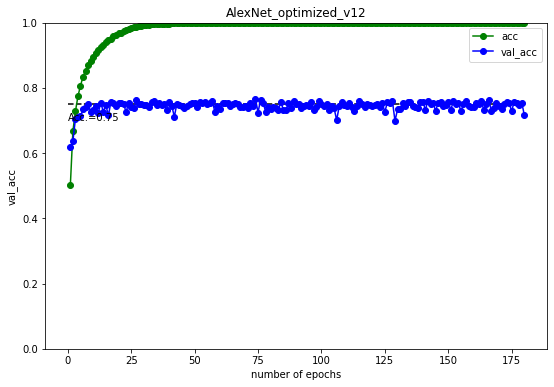

AlexNet_optimized_v16


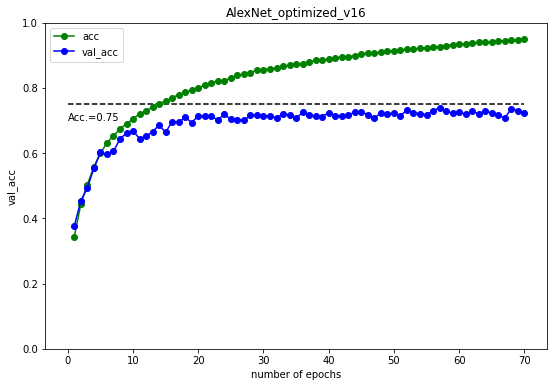

AlexNet_optimized_v2


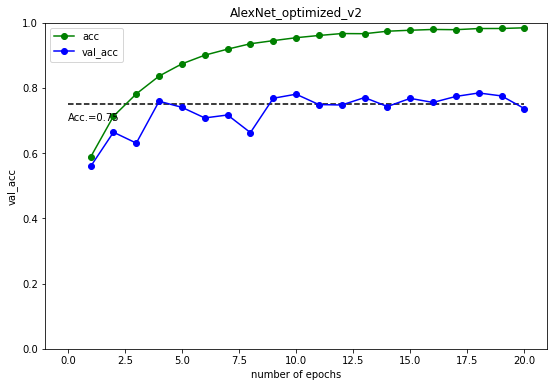

AlexNet_optimized_v28


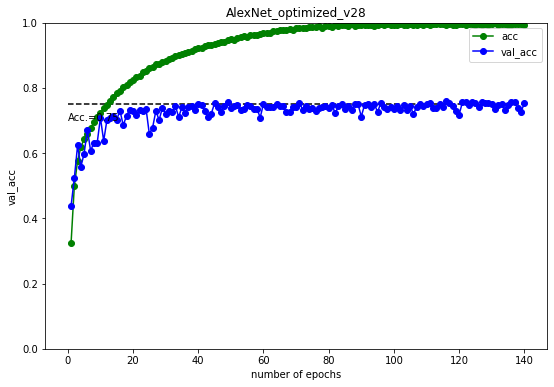

AlexNet_optimized_v6


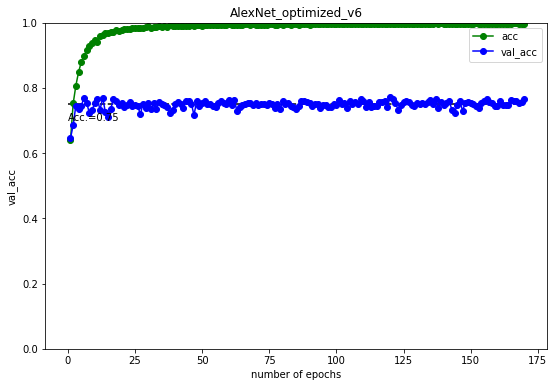

AlexNet_optimized_v20


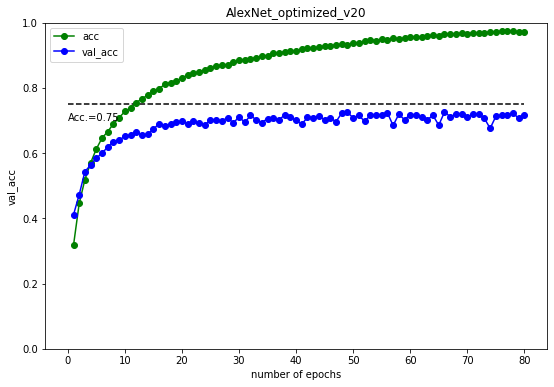

AlexNet_optimized_v24


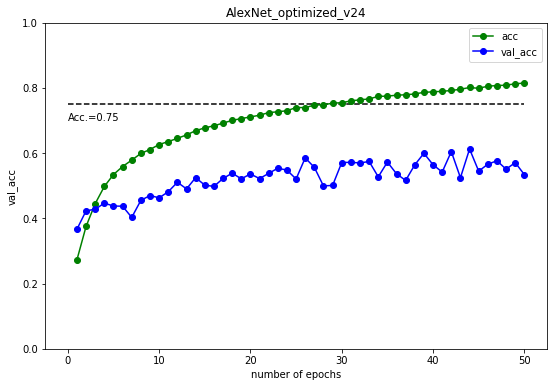

AlexNet_original_v2


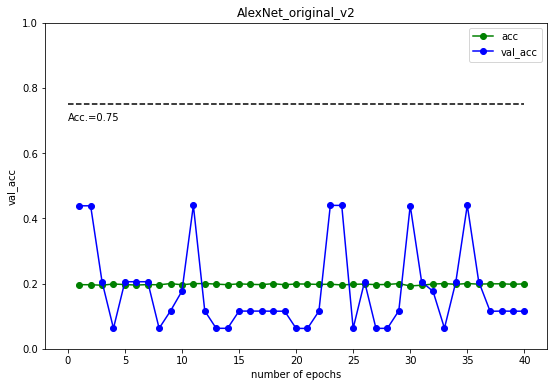

transferlearning_DenseNet121


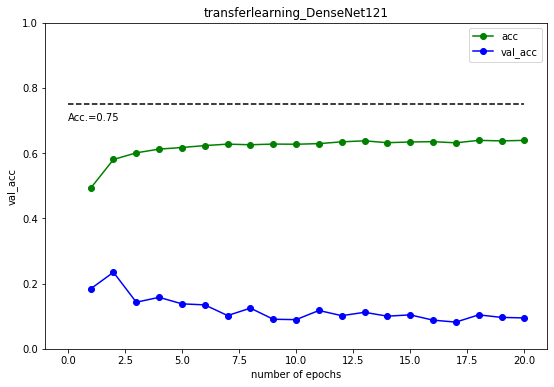

transferlearning_VGG19


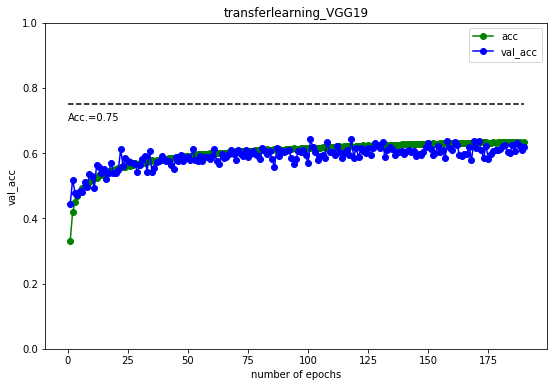

AlexNet_optimized_v21


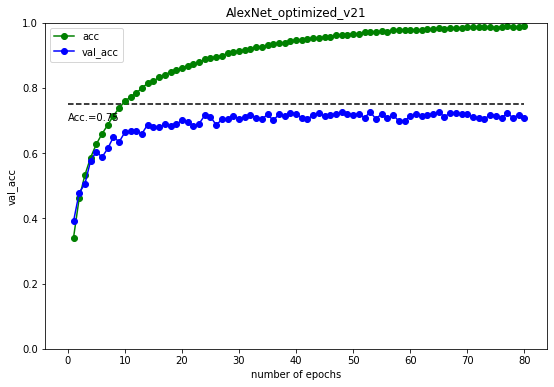

AlexNet_optimized_v25


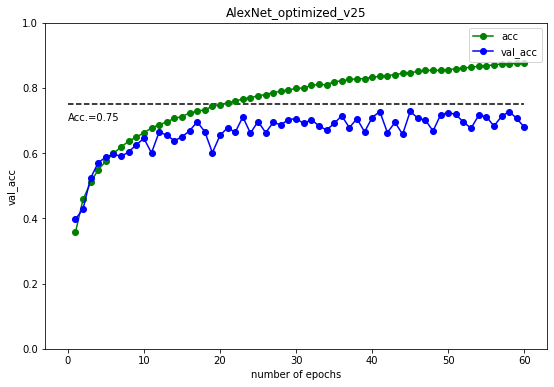

AlexNet_optimized_v3


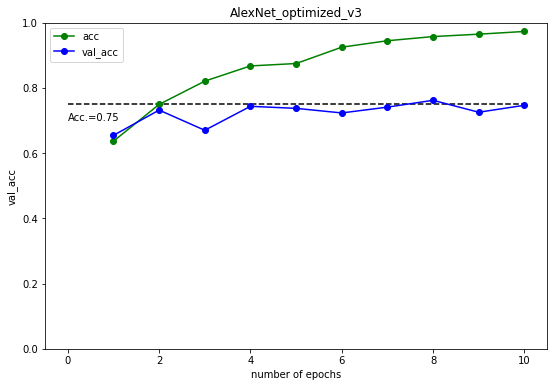

transferlearning_InceptionV3


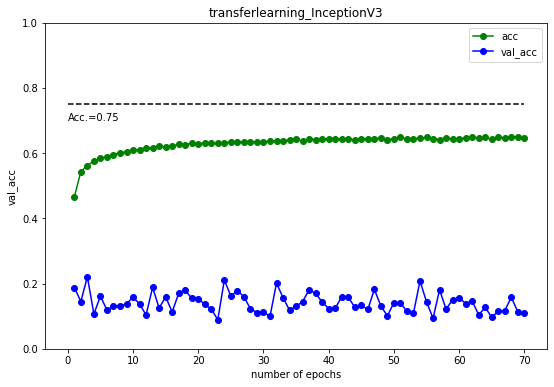

AlexNet_optimized_v29


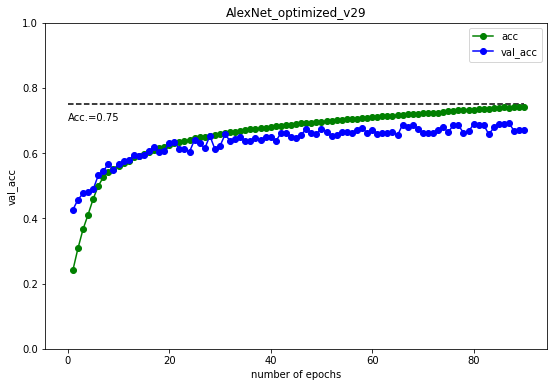

AlexNet_optimized_v7


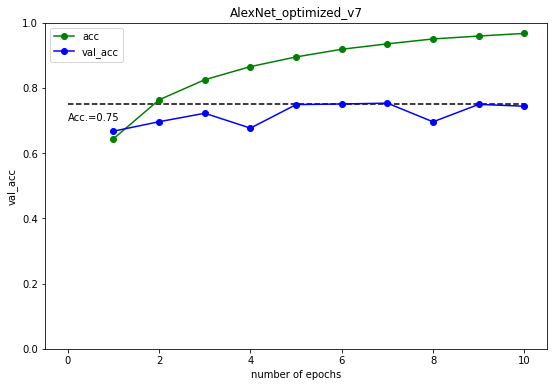

AlexNet_optimized_v40


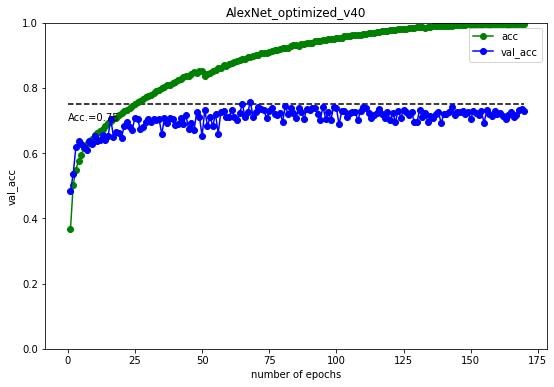

AlexNet_optimized


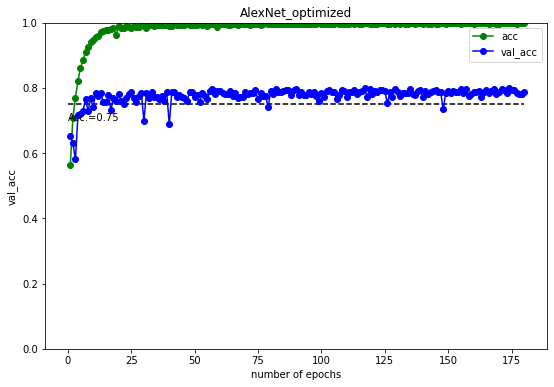

vgg_custom_net_1_v14


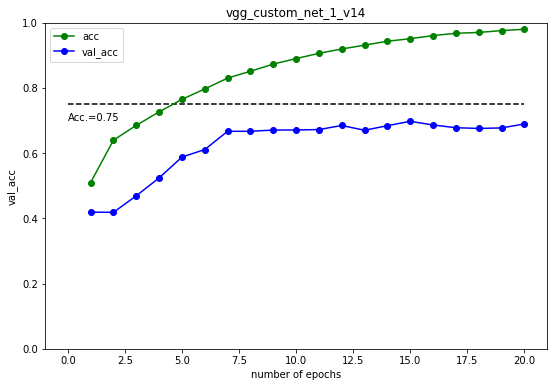

AlexNet_optimized_v38


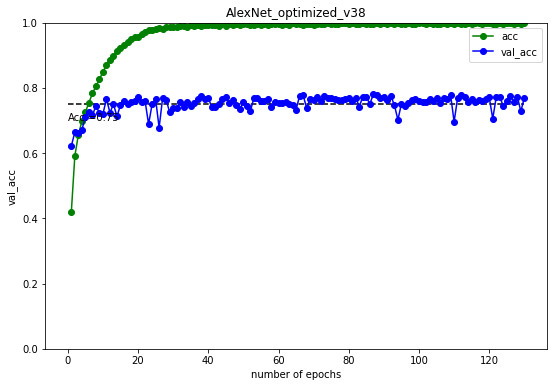

AlexNet_optimized_v17_imbalance


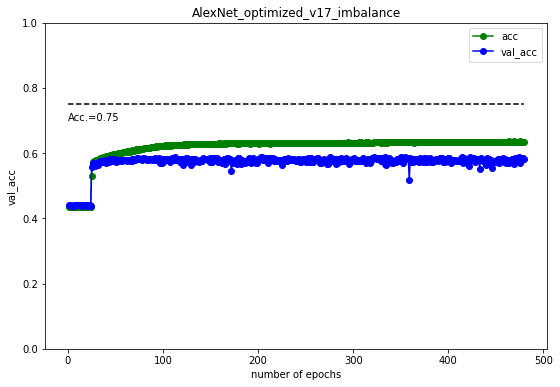

vgg_custom_net_1_v10


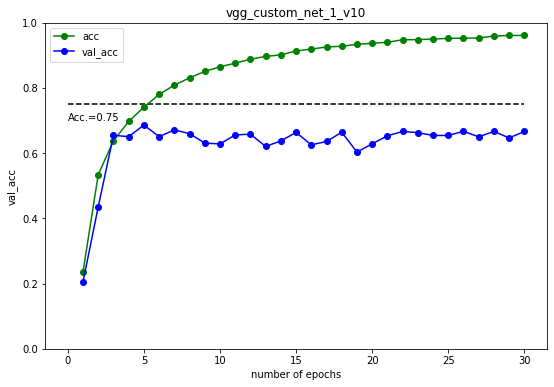

AlexNet_optimized_v34


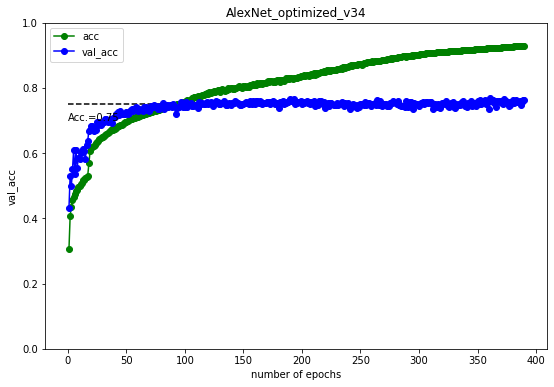

vgg_custom_net_1_v18


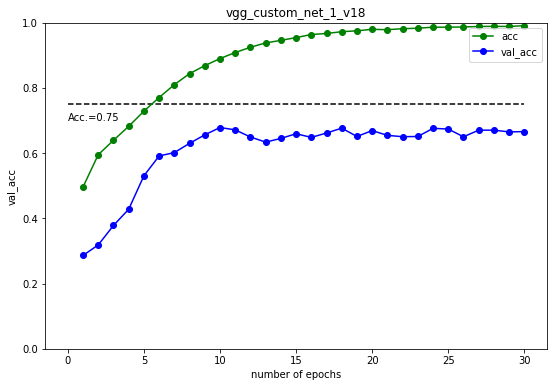

AlexNet_optimized_v30


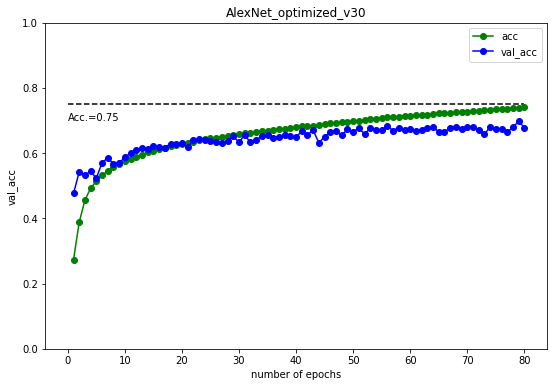

transferlearning_resnet50


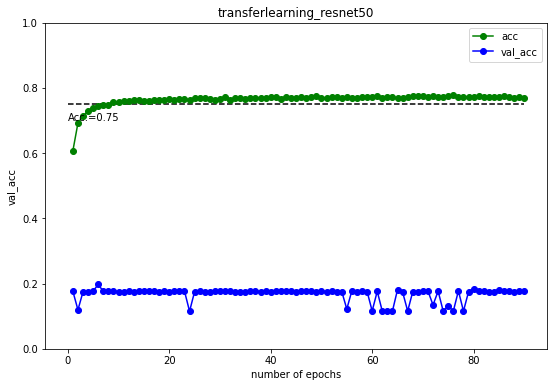

AlexNet_optimized_v13


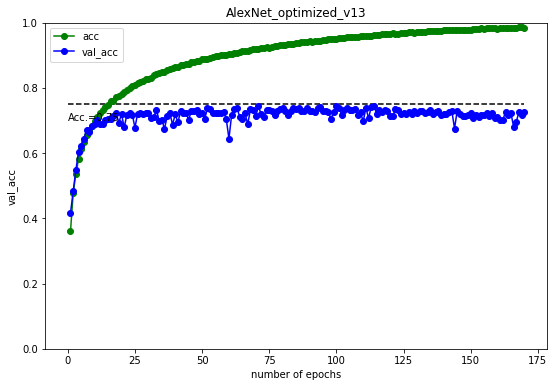

AlexNet_optimized_v17


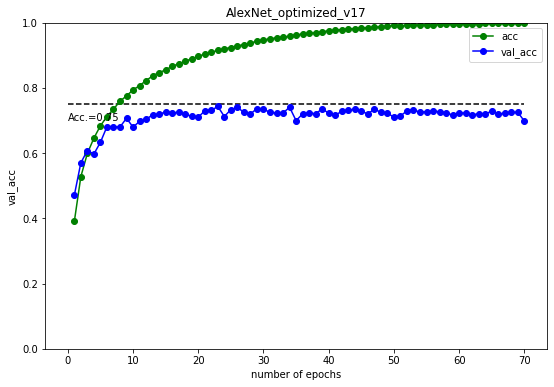

In [5]:
data = {}
targets = ["acc", "val_acc"]
line_style = ["-go", "-bo", "-ro", '-mo']
HISTORY_DIR_PATH = "./models_v2/history/"
history_subfolders = [(subfolder, join(HISTORY_DIR_PATH, subfolder)) for subfolder in listdir(HISTORY_DIR_PATH) if isdir(join(HISTORY_DIR_PATH, subfolder))]
for subdir, subdir_path in history_subfolders:
    split_sub = subdir.split('_')
    if split_sub[-1] == "history":
        histories = [(histo, join(subdir_path, histo)) for histo in listdir(subdir_path) if isfile(join(subdir_path, histo))]
        if not histories:
            continue
        epoch_list = []
        model_name = None
        for file_name, file_path in histories:
            pure_name = splitext(file_name)[0]
            split_pure_name = pure_name.split('_')
            
            if split_pure_name[0] != "000":
                try:
                    epoch_list.append((int(split_pure_name[-1]), file_path))
                    if not model_name:
                        model_name = "_".join(split_pure_name[:-1])
                except:
                    pass
        epoch_list.sort()
        
        
        all_stat = {}
        for target in targets:
            all_stat[target] = []
            
        for epoch_num, epoch_path in epoch_list:
            with open(epoch_path, 'rb') as handle:
                    histo = pickle.load(handle)
            for target in targets:
                all_stat[target] += histo[target]
        
        data[model_name] = {}
        print(model_name)
        plt.figure(1, (9,6))
        for idx, (k, v) in enumerate(all_stat.items()):
            plt.plot(list(range(1, epoch_list[-1][0]+1)), v, line_style[idx], label=k)
            data[model_name][k] = v
            
        plt.hlines(0.75, xmin=0, xmax=epoch_list[-1][0], linestyles='dashed')
        plt.text(x=0, y=0.70, s='Acc.=0.75')
        plt.ylim([0, 1])
        plt.legend(loc='best')
        plt.title(model_name)
        plt.xlabel("number of epochs")
        plt.ylabel(target)
        plt.show()
        

AlexNet_optimized_v34_no_others


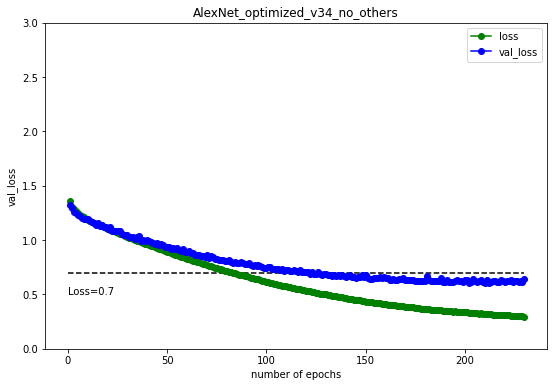

AlexNet_optimized_v23


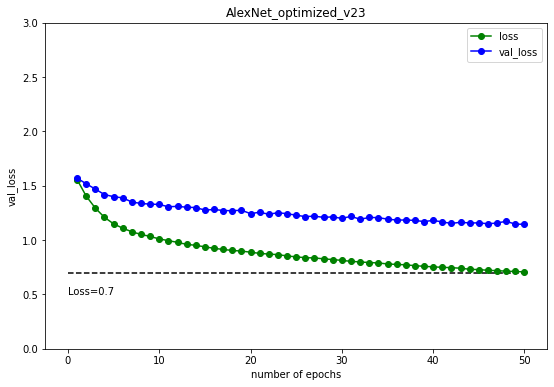

LeNet5


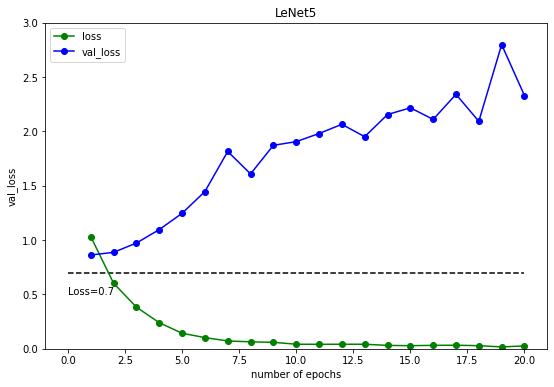

AlexNet_optimized_v9


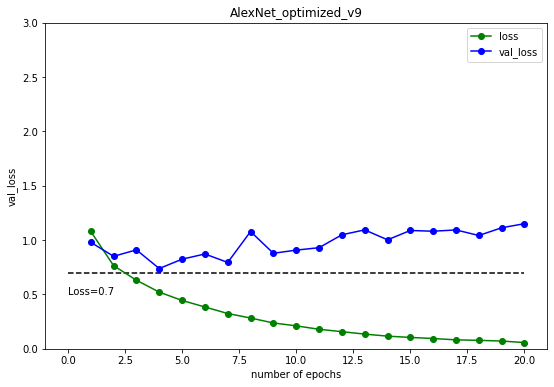

AlexNet_optimized_v27


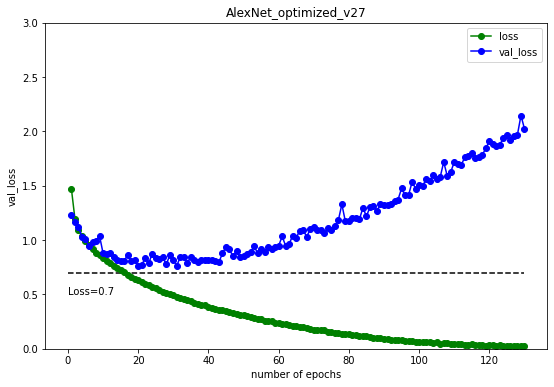

AlexNet_optimized_v5


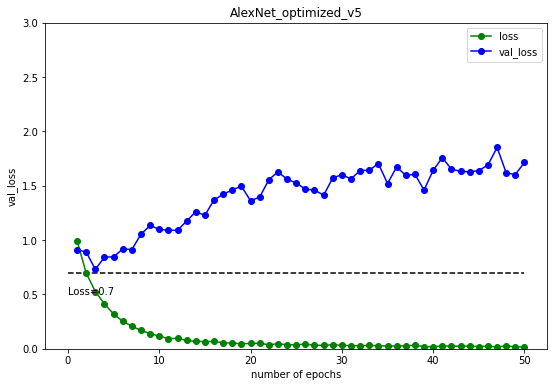

transferlearning_VGG16


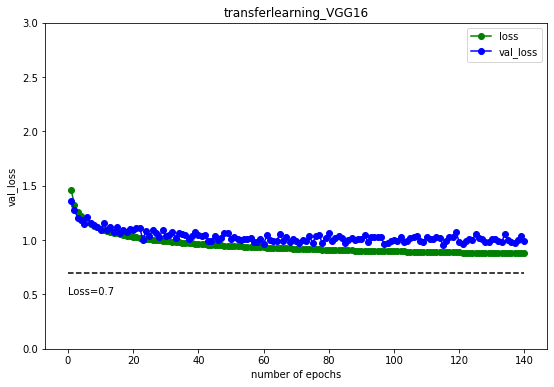

AlexNet_optimized_v19


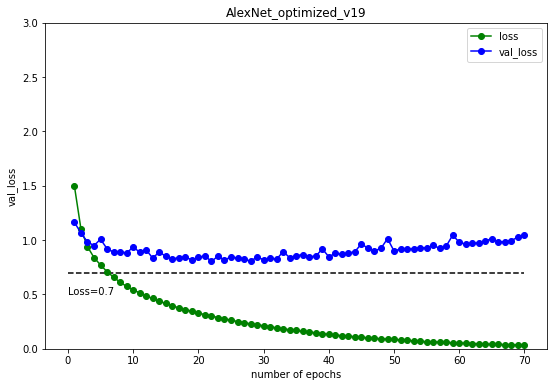

AlexNet_optimized_v11


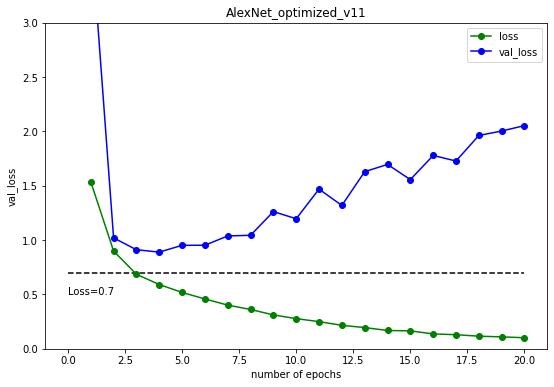

AlexNet_optimized_v15


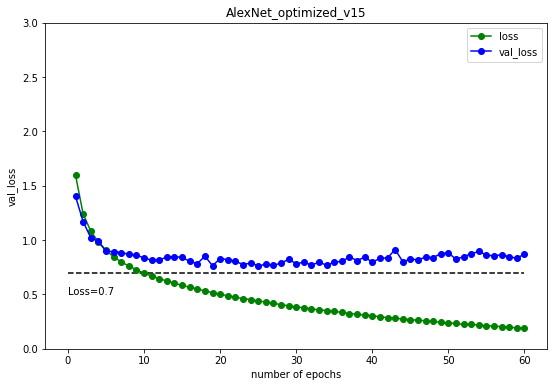

vgg_custom_net_1_v16


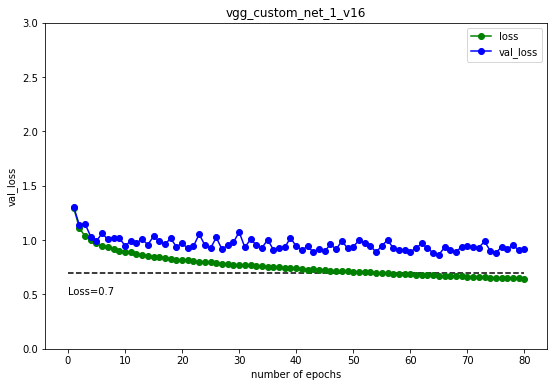

AlexNet_optimized_v4_imbalance


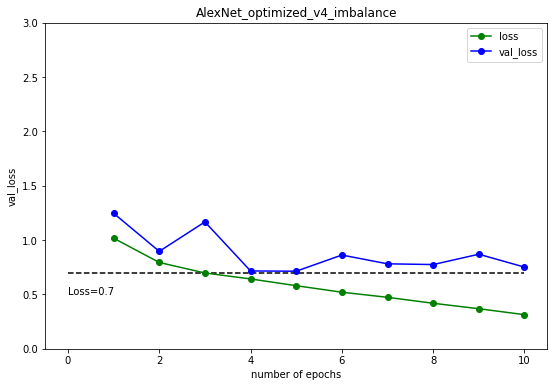

vgg_custom_net_1_v8


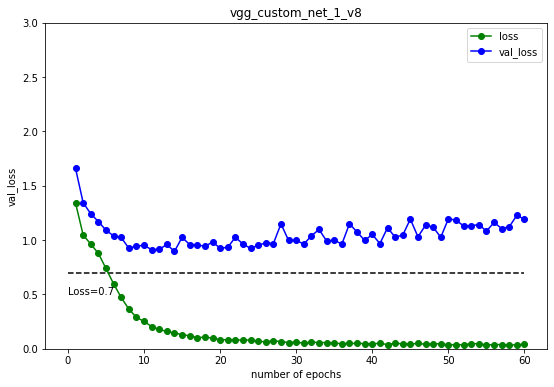

vgg_custom_net_1_v12


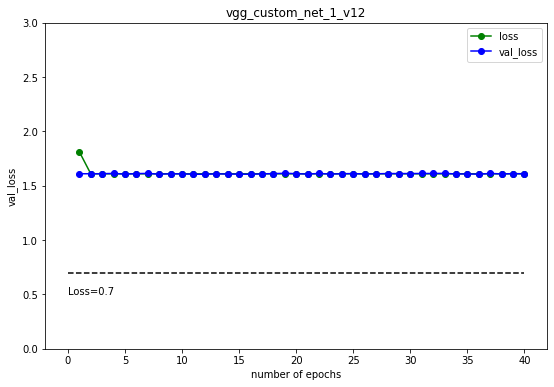

AlexNet_optimized_v36


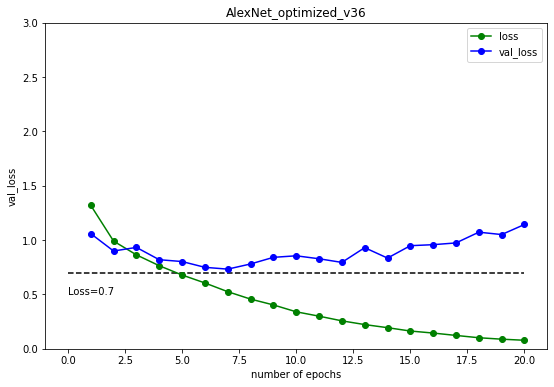

AlexNet_optimized_v32


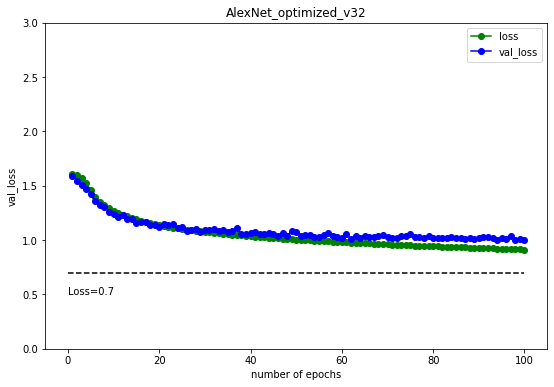

AlexNet_optimized_v10


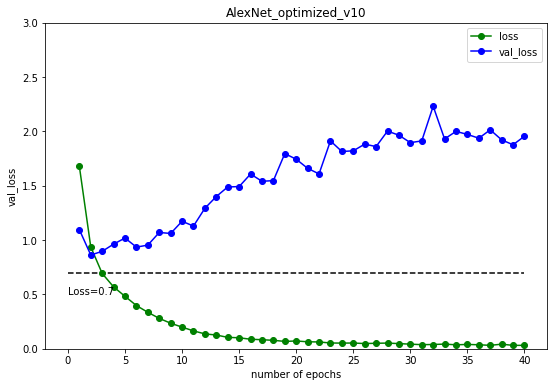

AlexNet_optimized_v14


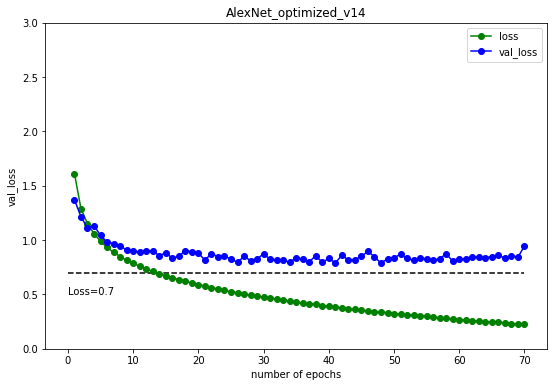

AlexNet_optimized_v18


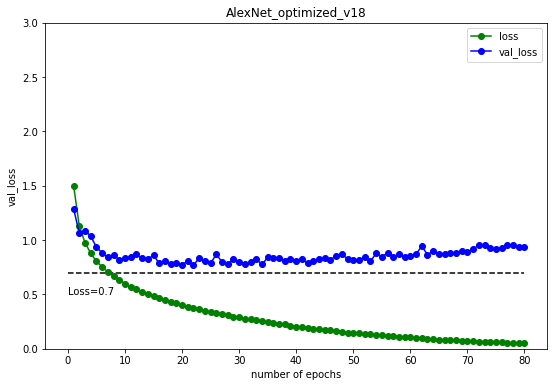

AlexNet_optimized_v37


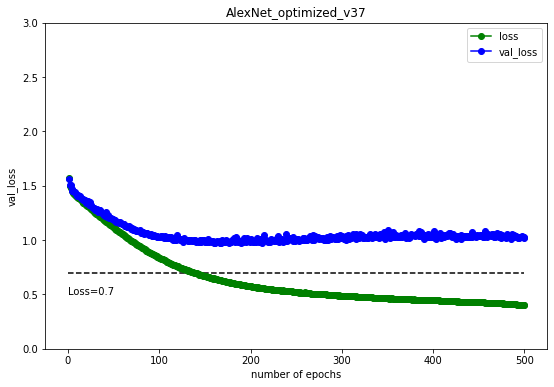

AlexNet_optimized_v33


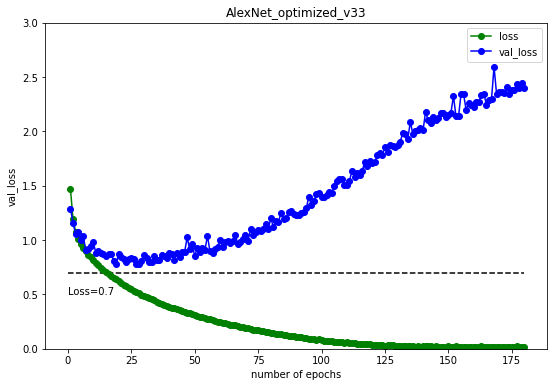

vgg_custom_net_1_v17


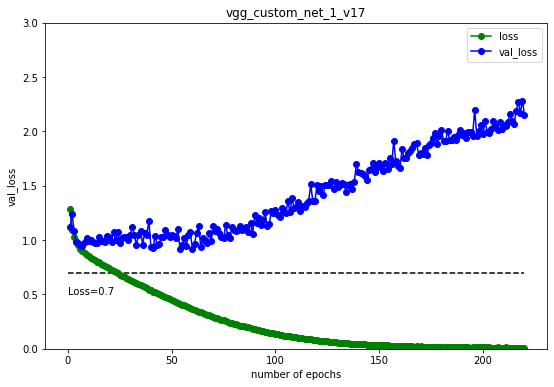

vgg_custom_net_1_v13


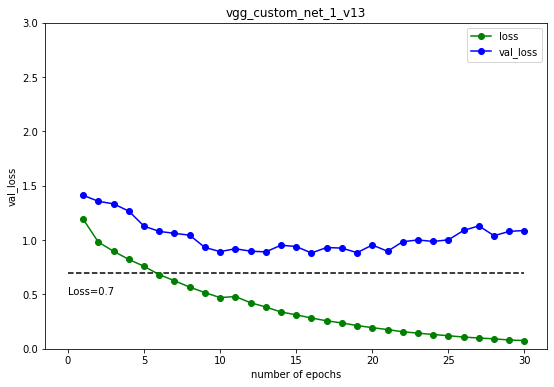

AlexNet_optimized_v15_imbalance


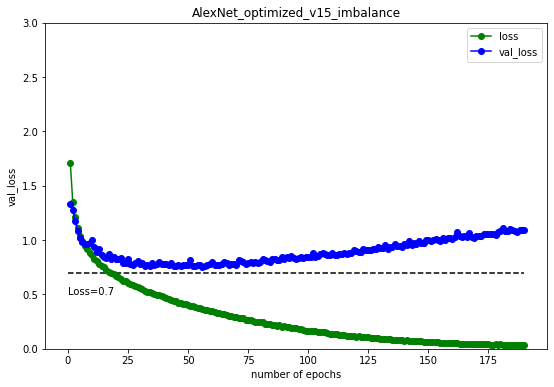

AlexNet_optimized_v4


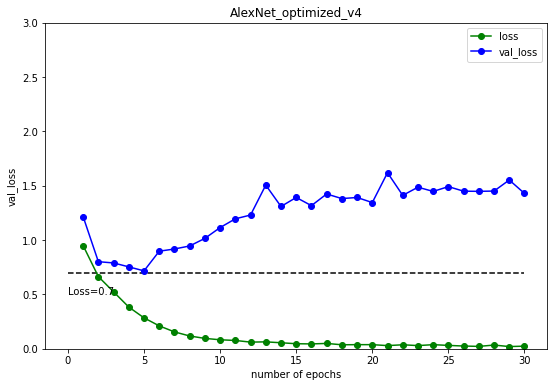

AlexNet_optimized_v22


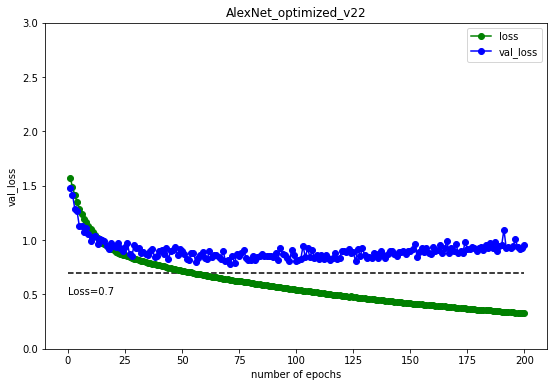

vgg_custom_net_1


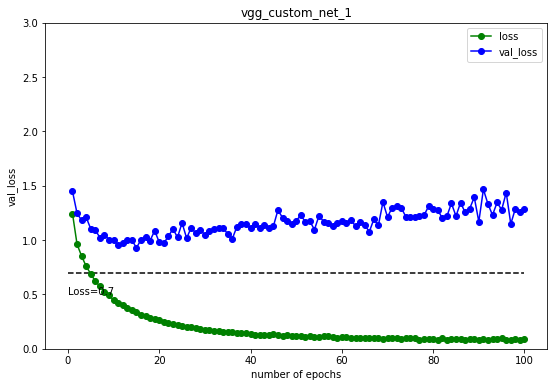

AlexNet_optimized_v8


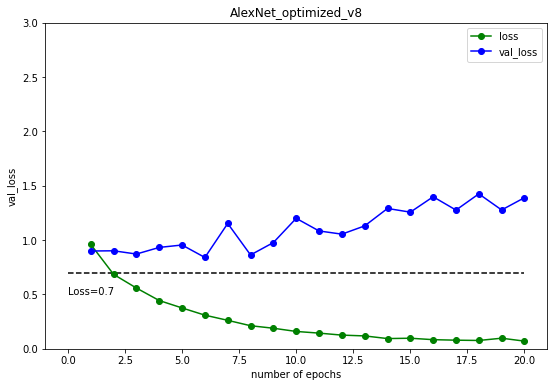

AlexNet_optimized_v26


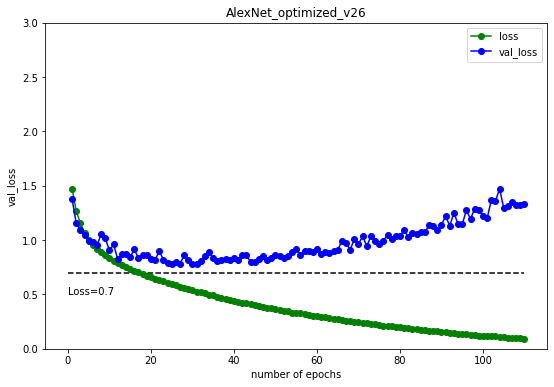

AlexNet_optimized_v35


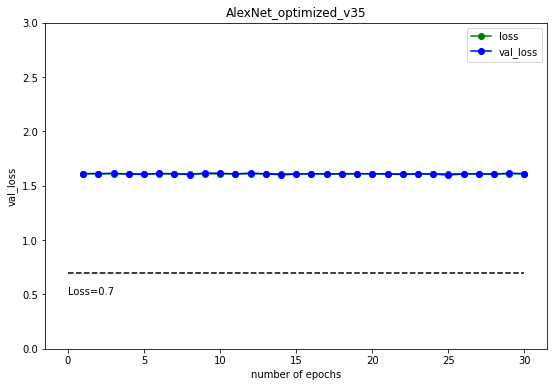

vgg_custom_net_1_v19


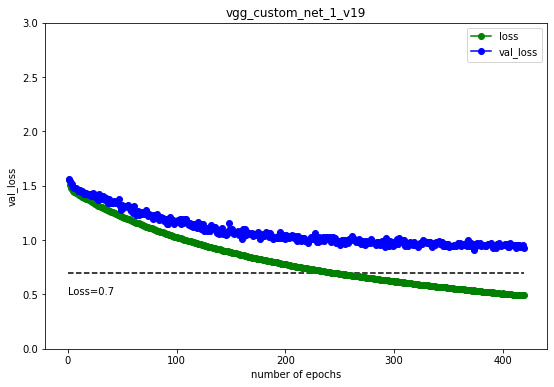

AlexNet_optimized_v31


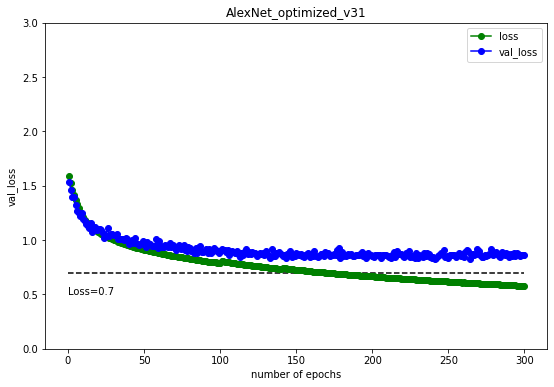

vgg_custom_net_1_v15


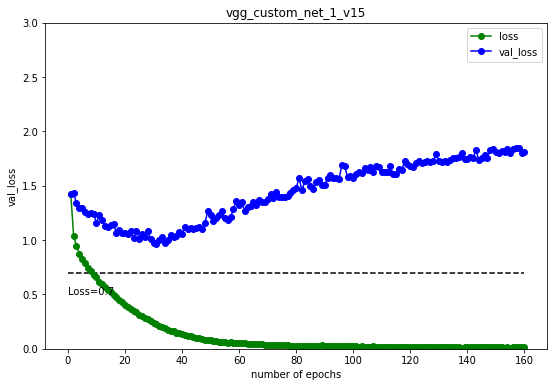

AlexNet_optimized_v39


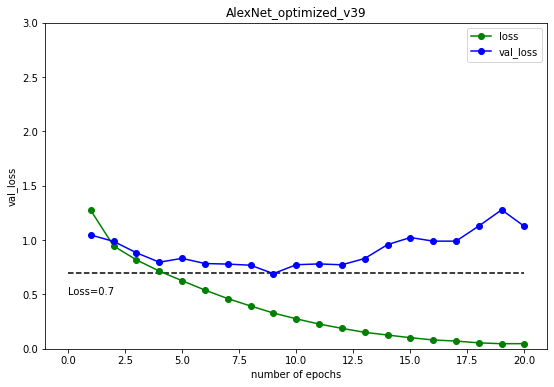

vgg_custom_net_1_v11


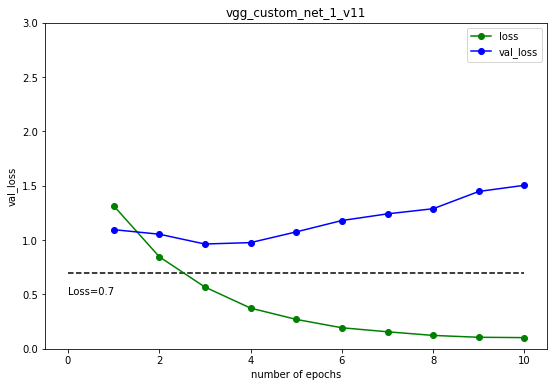

AlexNet_optimized_v12


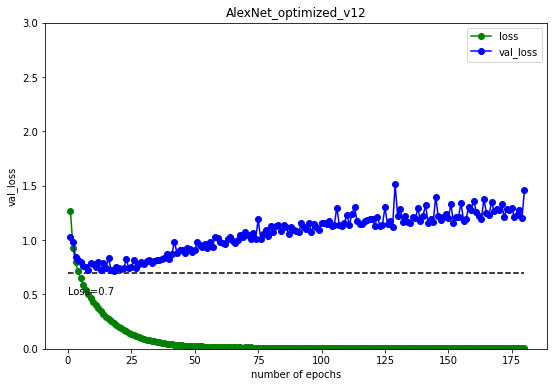

AlexNet_optimized_v16


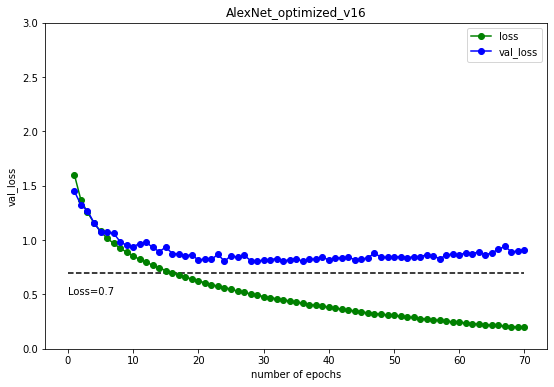

AlexNet_optimized_v2


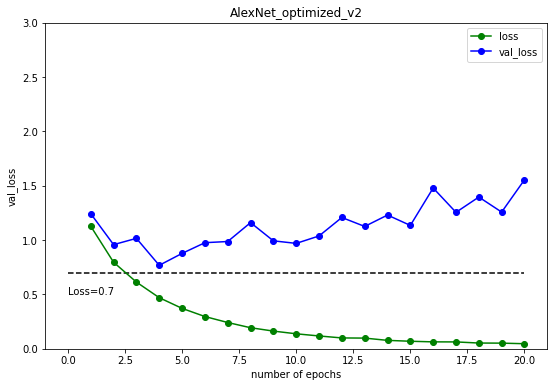

AlexNet_optimized_v28


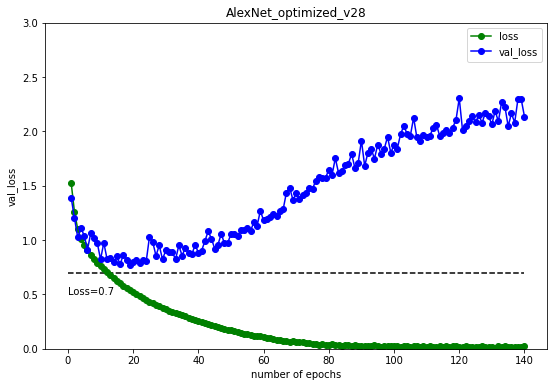

AlexNet_optimized_v6


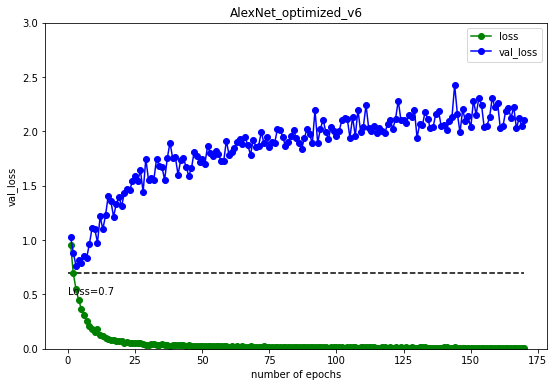

AlexNet_optimized_v20


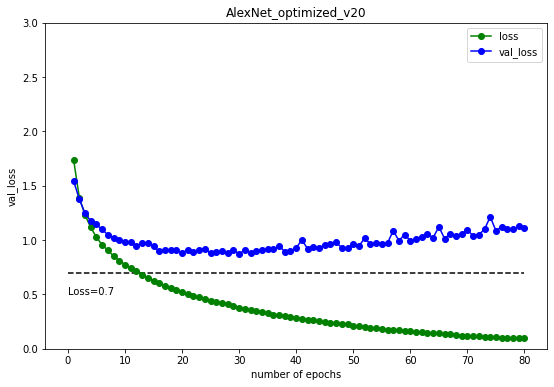

AlexNet_optimized_v24


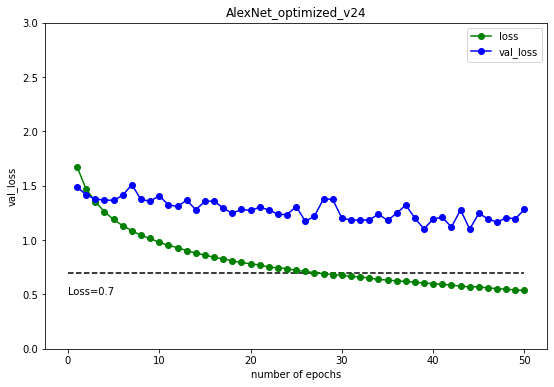

AlexNet_original_v2


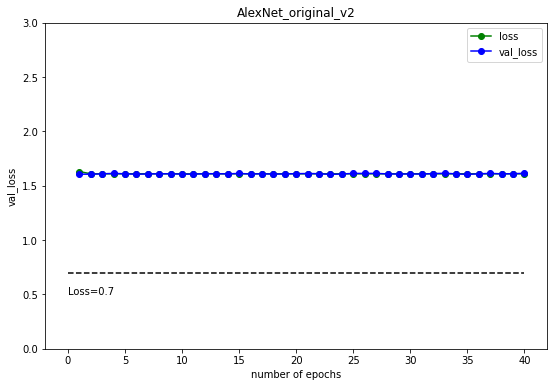

transferlearning_DenseNet121


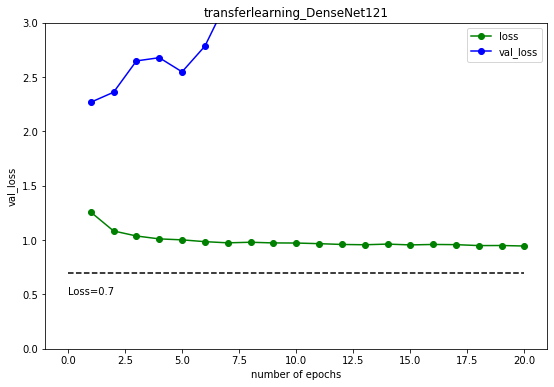

transferlearning_VGG19


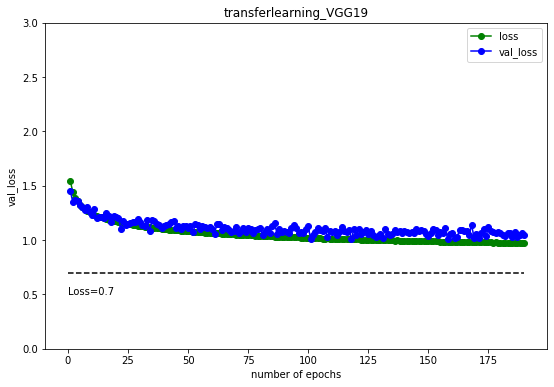

AlexNet_optimized_v21


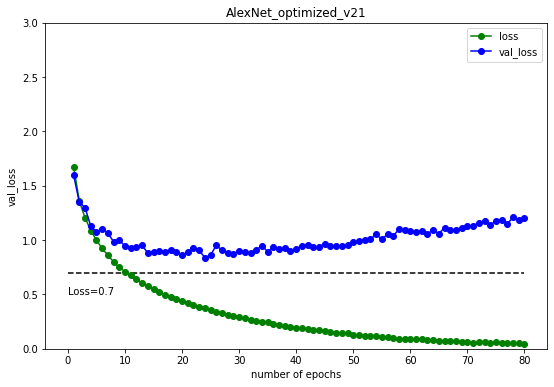

AlexNet_optimized_v25


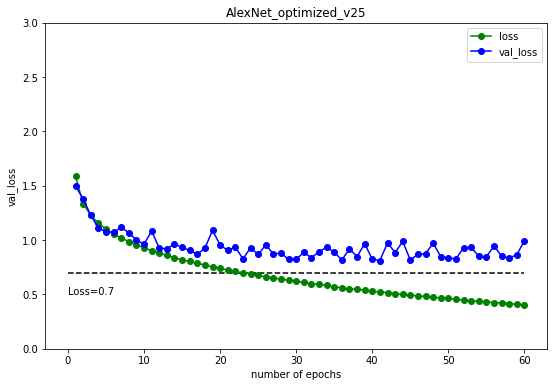

AlexNet_optimized_v3


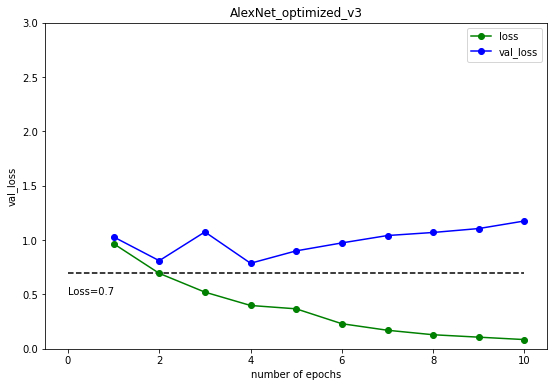

transferlearning_InceptionV3


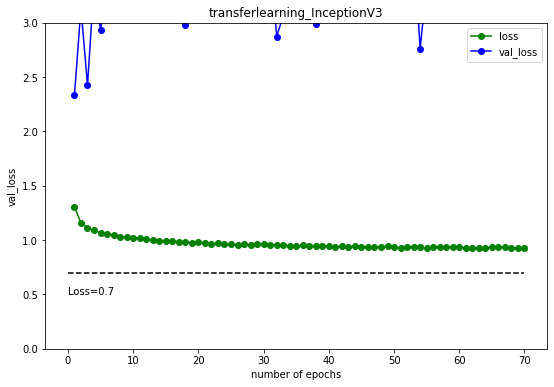

AlexNet_optimized_v29


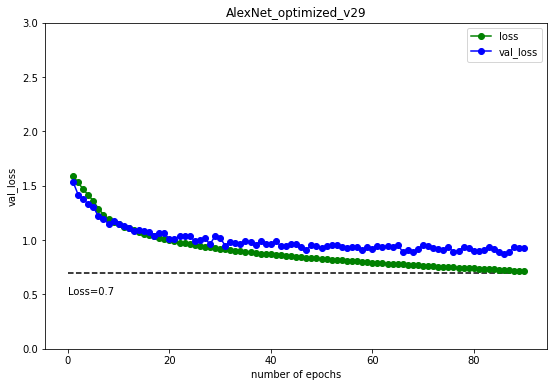

AlexNet_optimized_v7


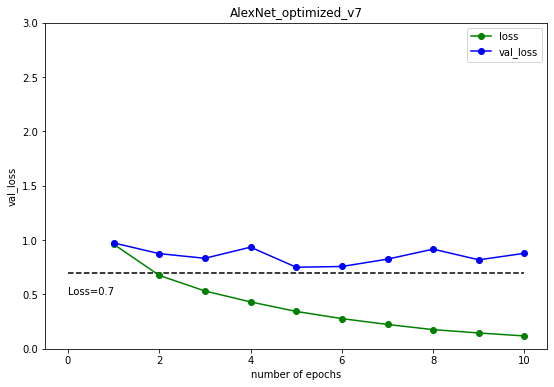

AlexNet_optimized_v40


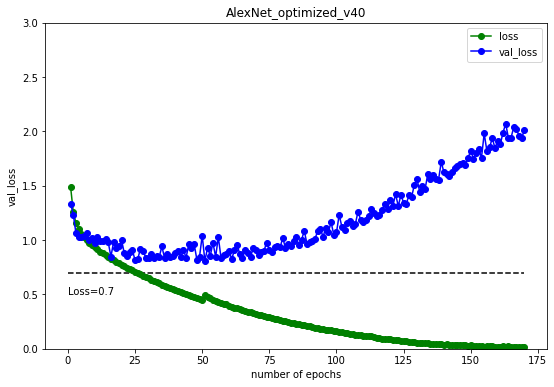

AlexNet_optimized


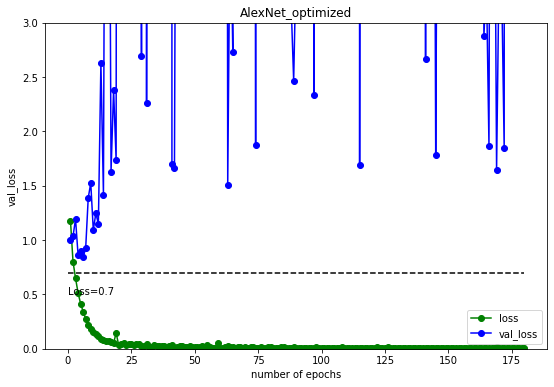

vgg_custom_net_1_v14


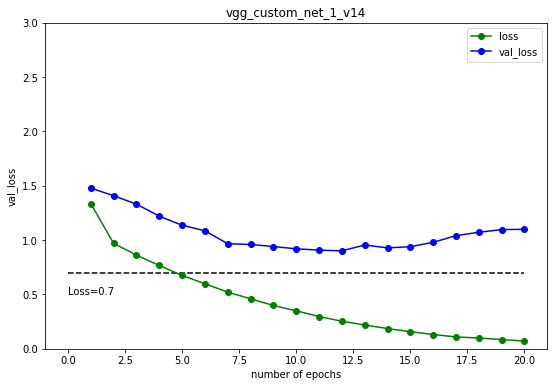

AlexNet_optimized_v38


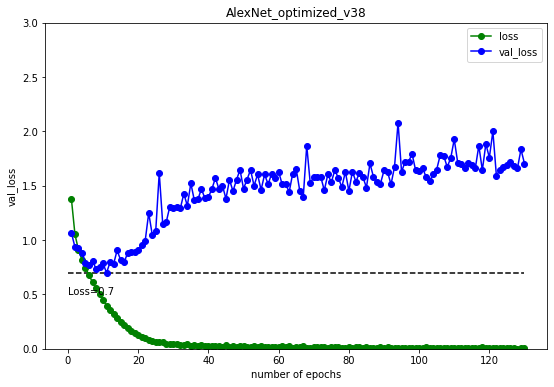

AlexNet_optimized_v17_imbalance


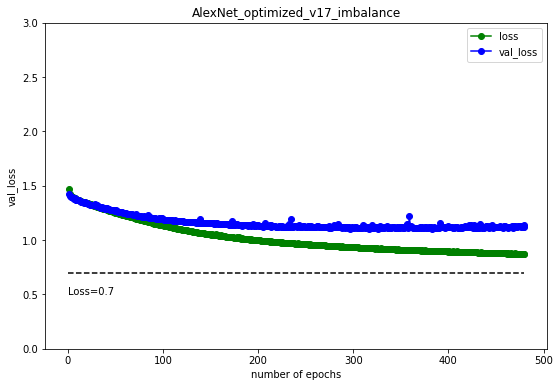

vgg_custom_net_1_v10


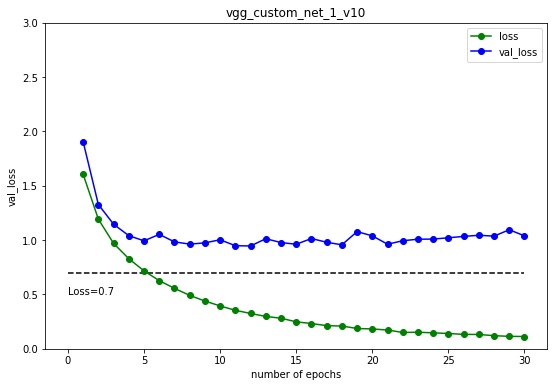

AlexNet_optimized_v34


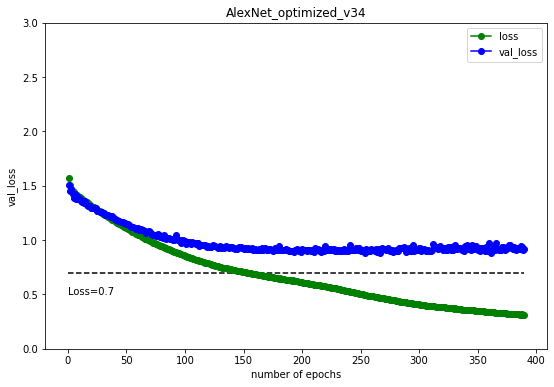

vgg_custom_net_1_v18


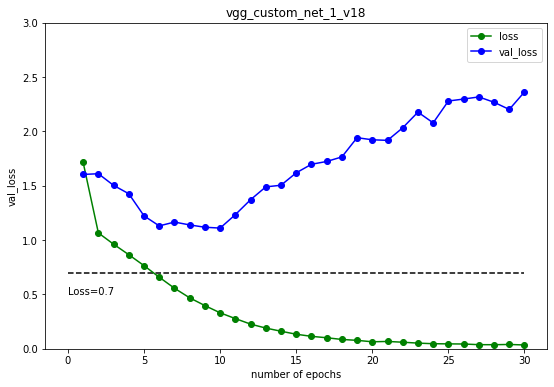

AlexNet_optimized_v30


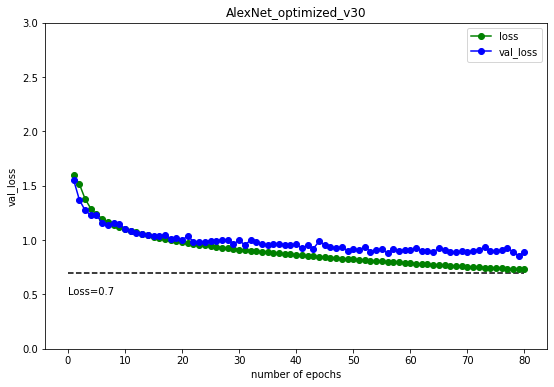

transferlearning_resnet50


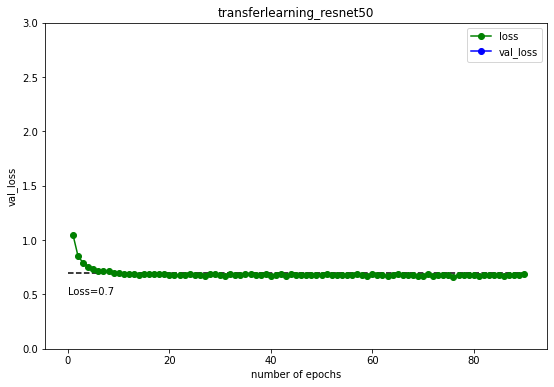

AlexNet_optimized_v13


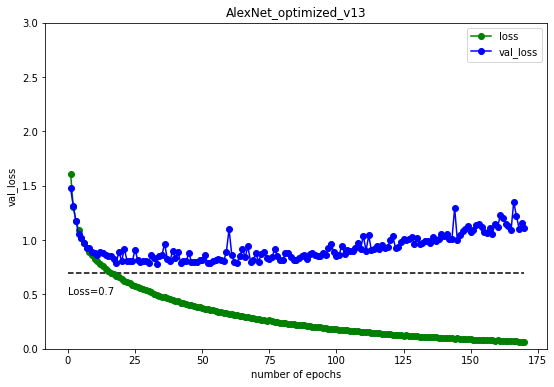

AlexNet_optimized_v17


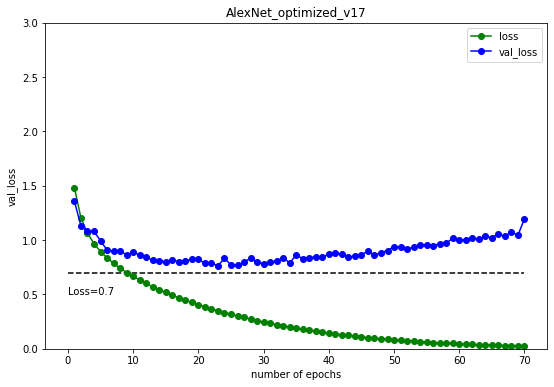

In [4]:
data = {}
targets = ["loss", "val_loss"]
line_style = ["-go", "-bo", "-ro", '-mo']
HISTORY_DIR_PATH = "./models_v2/history/"
history_subfolders = [(subfolder, join(HISTORY_DIR_PATH, subfolder)) for subfolder in listdir(HISTORY_DIR_PATH) if isdir(join(HISTORY_DIR_PATH, subfolder))]
for subdir, subdir_path in history_subfolders:
    split_sub = subdir.split('_')
    if split_sub[-1] == "history":
        histories = [(histo, join(subdir_path, histo)) for histo in listdir(subdir_path) if isfile(join(subdir_path, histo))]
        if not histories:
            continue
        epoch_list = []
        model_name = None
        for file_name, file_path in histories:
            pure_name = splitext(file_name)[0]
            split_pure_name = pure_name.split('_')
            
            if split_pure_name[0] != "000":
                try:
                    epoch_list.append((int(split_pure_name[-1]), file_path))
                    if not model_name:
                        model_name = "_".join(split_pure_name[:-1])
                except:
                    pass
        epoch_list.sort()
        
        
        all_stat = {}
        for target in targets:
            all_stat[target] = []
            
        for epoch_num, epoch_path in epoch_list:
            with open(epoch_path, 'rb') as handle:
                    histo = pickle.load(handle)
            for target in targets:
                all_stat[target] += histo[target]
        
        data[model_name] = {}
        print(model_name)
        plt.figure(1, (9,6))
        for idx, (k, v) in enumerate(all_stat.items()):
            plt.plot(list(range(1, epoch_list[-1][0]+1)), v, line_style[idx], label=k)
            data[model_name][k] = v
            
        plt.hlines(0.7, xmin=0, xmax=epoch_list[-1][0], linestyles='dashed')
        plt.text(x=0, y=0.5, s='Loss=0.7')
        plt.ylim([0, 3])
        plt.legend(loc='best')
        plt.title(model_name)
        plt.xlabel("number of epochs")
        plt.ylabel(target)
        plt.show()
        

In [10]:
from sklearn.metrics import classification_report
model = load_model("./models_v2/vgg_custom_net_1_v19/000_vgg_custom_net_1_v19_best_loss_130.h5")
train_per = model.evaluate(training_generator, verbose=1)
val_per = model.evaluate(validation_generator, verbose=1)
test_per = model.evaluate(test_generator, verbose=1)
print("Train accuracy:", train_per[1])
print("Validation accuracy:", val_per[1])
print("Test accuracy:", test_per[1])
y_pred = model.predict_generator(test_generator, verbose=1)
y_pred_t = []
for entry in y_pred:
    y_pred_t.append(np.argmax(entry))
target =["white", "black", "asian", "indian", "Others"]
print(classification_report(list(y_test.values()), y_pred_t, target_names=target))

4027/4027 [==============================] - 26s 6ms/step - loss: 1.0810 - acc: 0.6792
Train accuracy: 0.68378574
Validation accuracy: 0.6678125
Test accuracy: 0.67916566
4027/4027 [==============================] - 23s 6ms/step
              precision    recall  f1-score   support

       white       0.90      0.65      0.75      1775
       black       0.72      0.84      0.78       828
       asian       0.68      0.66      0.67       500
      indian       0.53      0.73      0.61       672
      Others       0.20      0.29      0.23       252

    accuracy                           0.68      4027
   macro avg       0.60      0.63      0.61      4027
weighted avg       0.73      0.68      0.69      4027



In [9]:
from sklearn.metrics import classification_report
model = load_model("./models_v2/AlexNet_optimized_v34/000_AlexNet_optimized_v37_best_loss_110.h5")
train_per = model.evaluate(training_generator, verbose=1)
val_per = model.evaluate(validation_generator, verbose=1)
test_per = model.evaluate(test_generator, verbose=1)
print("Train accuracy:", train_per[1])
print("Validation accuracy:", val_per[1])
print("Test accuracy:", test_per[1])
y_pred = model.predict_generator(test_generator, verbose=1)
y_pred_t = []
for entry in y_pred:
    y_pred_t.append(np.argmax(entry))
target =["white", "black", "asian", "indian", "Others"]
print(classification_report(list(y_test.values()), y_pred_t, target_names=target))

4027/4027 [==============================] - 30s 8ms/step - loss: 0.9517 - acc: 0.7584
Train accuracy: 0.74775
Validation accuracy: 0.7434375
Test accuracy: 0.75838095
4027/4027 [==============================] - 25s 6ms/step
              precision    recall  f1-score   support

       white       0.84      0.83      0.83      1775
       black       0.83      0.85      0.84       828
       asian       0.59      0.83      0.69       500
      indian       0.70      0.67      0.68       672
      Others       0.24      0.08      0.12       252

    accuracy                           0.76      4027
   macro avg       0.64      0.65      0.63      4027
weighted avg       0.75      0.76      0.75      4027



# What are being missclassified?


In [1]:
# === Commented out because it takes too much space as it outputs lots of images ===
model = load_model("./models_v2/AlexNet_optimized_v34/000_AlexNet_optimized_v34_best_loss_110.h5")
label = ["white", "black", "asian", "indian", "others"]
pred = model.predict(test_generator, verbose=1)
for i, key in enumerate(y_test):
    if i < len(pred):
        item = pred[i]
        if (np.argmax(item) != y_test[key]):
            image_path = join(FILTERED_DIR, key)
            image = cv2.imread(image_path)
            printImage(image)
            print("ground_truth: ",label[y_test[key]])
            print("prediction: ", label[np.argmax(item)], item )
